In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns 
import re
 
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.inspection import permutation_importance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic,Exponentiation
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter, ConstantKernel
from sklearn.gaussian_process.kernels import GenericKernelMixin

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  

from sklearn.pipeline import make_pipeline

from sklearn.base import clone

In [3]:
def run_models():
    rf = RandomForestRegressor(n_estimators=10, criterion='squared_error', 
                               min_samples_split=2, min_samples_leaf=1, max_features='sqrt')
    gb = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                n_estimators=100, max_depth=10,
                                learning_rate=0.25, min_samples_leaf=9,
                                min_samples_split=2)
    rr = Ridge(alpha=0.01)
    lasso = Lasso(alpha=0.001)
    gpr1 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=DotProduct() + WhiteKernel(),
                                    alpha=0.1, n_restarts_optimizer=1)
    gpr2 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(RBF(length_scale=1.0), exponent=2) + 
                                    WhiteKernel(noise_level=0.1), alpha=0.1E-4, n_restarts_optimizer=1)
    gpr3 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(RationalQuadratic(length_scale=1.0, 
                                                                                        alpha=0.01), exponent=2),
                                    alpha=0.001, n_restarts_optimizer=1)
    gpr4 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(Matern(length_scale=1.0, nu=1.5), exponent=2),
                                    alpha=0.01, n_restarts_optimizer=1)
    models = [rf,gb,rr,lasso,gpr1,gpr2,gpr3,gpr4]
    models_names = ["RF","GB","RR","LASSO","gpr1","gpr2","gpr3","gpr4"]
    r2scores=[]
    rmse=[]
    count=0
    for model in models :
        model.fit(X,Y)
        predicted = model.predict(X_test)
        r2=sklearn.metrics.r2_score(Y_test, predicted)
        Y_unscaled = scaler.inverse_transform(np.array(Y_test).reshape(-1,1))
        predicted_unscaled = scaler.inverse_transform(np.array(predicted).reshape(-1,1))
        r2scores.append(r2)
        err=np.sqrt(mean_squared_error(Y_test,predicted))
        err_unscaled=np.sqrt(mean_squared_error(Y_unscaled,predicted_unscaled))
        rmse.append(err_unscaled)
        print(models_names[count],r2)
        print("RMSE: ",err)
        print("RMSE unscaled: ",err_unscaled)
        print("----------------------------------------")
        fig, ax = plt.subplots()
        ax.scatter(Y_unscaled, predicted_unscaled)
        ax.plot([Y_unscaled.min(), predicted_unscaled.max()], [Y_unscaled.min(), predicted_unscaled.max()], 'r--', lw=1)
        #for i in range(len(Y_test)):
        #    plt.annotate(text[i], (Y_test[i], predicted[i]))
        ax.set_xlabel("Calculated, ZPE (kJ/mol))",fontsize= 20)
        ax.set_ylabel("Predicted, ZPE (kJ/mol))",fontsize= 20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        ax.tick_params(direction='in', length=10, width=2)
        for axis in ['top','bottom','left','right']:
              ax.spines[axis].set_linewidth(2)
        #plt.savefig('kl_train.eps', format='eps', bbox_inches='tight',pad_inches = 0)
        plt.show()
        count+=1
    plt.rcdefaults()
    fig, ax = plt.subplots()

    x_pos = np.arange(len(models_names))
    ax.bar(x_pos, r2scores, align='center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models_names)
    ax.set_ylabel('R2 Score')
    #plt.savefig('imp.eps', format='eps')
    plt.show()

In [4]:
def get_RF_feature_importance():
    features= X
    feature_list = list(features.columns)
    rf = RandomForestRegressor(n_estimators= 15, random_state=1)
    rf.fit(X , Y)

    # Get numerical feature importances
    importances = list(rf.feature_importances_)      
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, 
                           importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [5]:
data = pd.read_csv('Combined_all_3rd_fit.csv', encoding='cp1252')
print(data.columns.values)  

['Name' 'Coef_a' 'Coef_b' 'Coef_c' 'Coef_d' 'A_site' 'B_site' 'X_site'
 'Spacegroup' 'Ehull' 'BulkModulus' 'Energy' 'ZPE' 's_A' 's_B' 's_X'
 'density' 'mean_A2B' 'mean_A2X' 'mean_B2X' 'mean_X2X' 'std_A2B' 'std_A2X'
 'std_B2X' 'std_X2X' 'E_coh' 'TF' 'OF' 'A_Z' 'B_Z' 'X_Z' 'A_M' 'B_M' 'X_M'
 'A_G' 'B_G' 'X_G' 'A_IEI' 'B_IEI' 'X_IEI' 'A_IEII' 'B_IEII' 'X_IEII'
 'A_EA' 'B_EA' 'X_EA' 'A_ChiP' 'B_ChiP' 'X_ChiP' 'A_ChiA' 'X_ChiA'
 'A_Rvdw' 'B_Rvdw' 'X_Rvdw' 'A_Rc' 'B_Rc' 'X_Rc' 'A_Ra' 'B_Ra' 'X_Ra'
 'A_MP' 'B_MP' 'X_MP' 'A_BP' 'B_BP' 'X_BP' 'A_Rho' 'B_Rho' 'A_MV' 'B_MV'
 'X_MV' 'A_Hf' 'B_Hf' 'X_Hf' 'A_Hv' 'B_Hv' 'X_Hv' 'A_Kappa' 'B_Kappa'
 'X_Kappa' 'A_CvM' 'B_CvM' 'X_CvM' 'A_B' 'B_B' 'X_B' 'A_MendeleevNo'
 'B_MendeleevNo' 'X_MendeleevNo']


In [6]:
data.drop(['Name', 'A_site', 'B_site', 'X_site', 'Spacegroup','BulkModulus',
           'Ehull','Energy','ZPE','Coef_a', 'Coef_c', 'Coef_d'], axis=1, inplace = True)
target = 'Coef_b'

In [7]:
data.fillna(0, inplace= True)
d=data.copy()
columns = list(d.columns.values)

# Standard Scaling

In [8]:
data_std=d.copy()
scaler=StandardScaler()
scaler.fit(np.array(data[target]).reshape(-1, 1))
data_zpe_std= scaler.transform(np.array(data[target]).reshape(-1, 1))
data_std[columns]= StandardScaler().fit_transform(d[columns])
Y = data_std[target] 
X = data_std.drop([target], axis=1)

In [9]:
correlated_features = ["A_Rc","A_Ra","A_M","A_MP","A_MV","A_MendeleevNo","A_Hf","A_Hv","B_Rc",
                       "B_Rvdw","B_M","B_BP","B_MendeleevNo","B_Hv","X_Rc","X_Rvdw","X_M","X_BP","X_MP",
                       "X_MendeleevNo","X_Hf","X_Hv","X_G","X_B","X_CvM","X_ChiP"]
data_std.drop(labels=correlated_features, axis=1, inplace=True)
print(data_std.shape)
Y = data_std[target] 
X = data_std.drop([target], axis=1)

(80, 51)


### Test-train splitting 

In [10]:
# split into train and test
df_train, df_test = train_test_split(data_std, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state =50)
df_train.reset_index(inplace = True)
df_test.reset_index(inplace = True)
df_train=df_train.drop('index',axis=1)
df_test=df_test.drop('index',axis=1)
# divide into X_train, y_train, X_test, y_test
Y = df_train.pop(target)
X = df_train

Y_test = df_test.pop(target)
X_test = df_test

RF 0.8586870000806246
RMSE:  0.3838094648403188
RMSE unscaled:  2.1786527295373958e-05
----------------------------------------


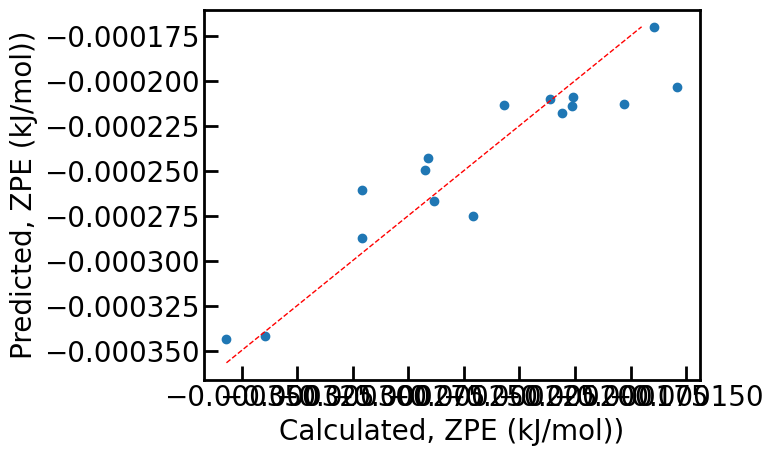

GB 0.8391837766190171
RMSE:  0.4094393242315983
RMSE unscaled:  2.3241378419061132e-05
----------------------------------------


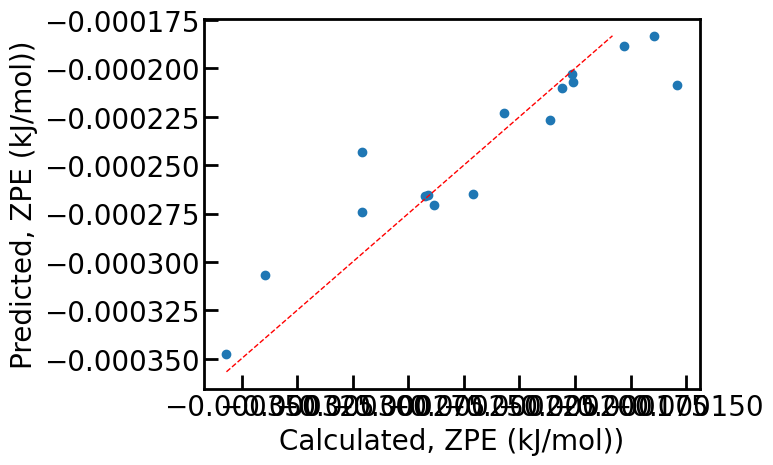

RR 0.7620407232287474
RMSE:  0.4980534381500456
RMSE unscaled:  2.8271462323956073e-05
----------------------------------------


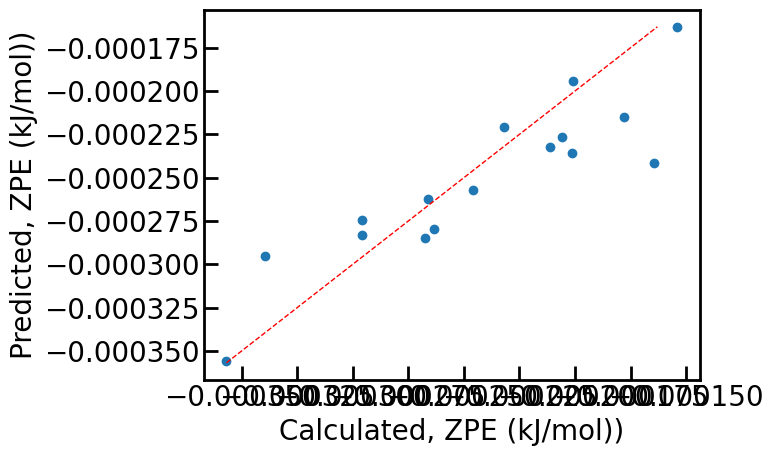

LASSO 0.884375125673382
RMSE:  0.34717645090085086
RMSE unscaled:  1.9707094057748938e-05
----------------------------------------


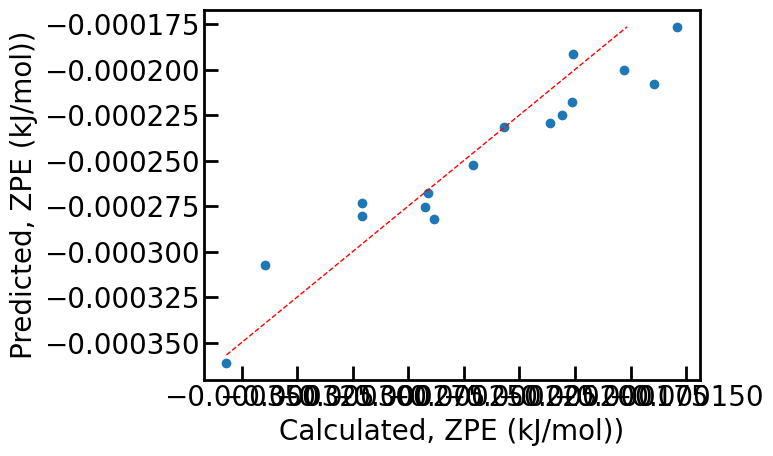

gpr1 0.8583825213745528
RMSE:  0.3842227280511655
RMSE unscaled:  2.1809985732562403e-05
----------------------------------------


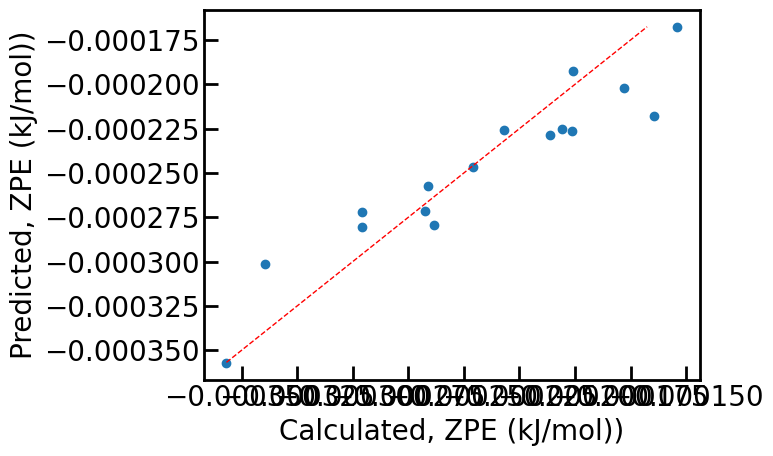

gpr2 0.9250948366853899
RMSE:  0.2794348057912367
RMSE unscaled:  1.5861813168628173e-05
----------------------------------------


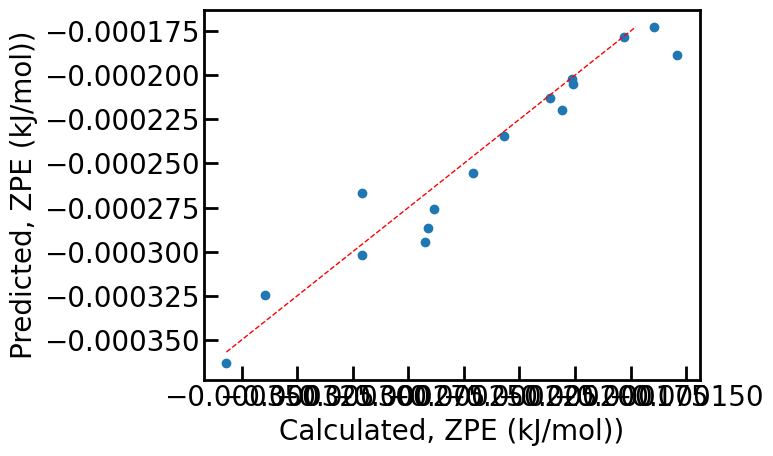

gpr3 0.9280057788482061
RMSE:  0.27395134764519335
RMSE unscaled:  1.5550550624278166e-05
----------------------------------------


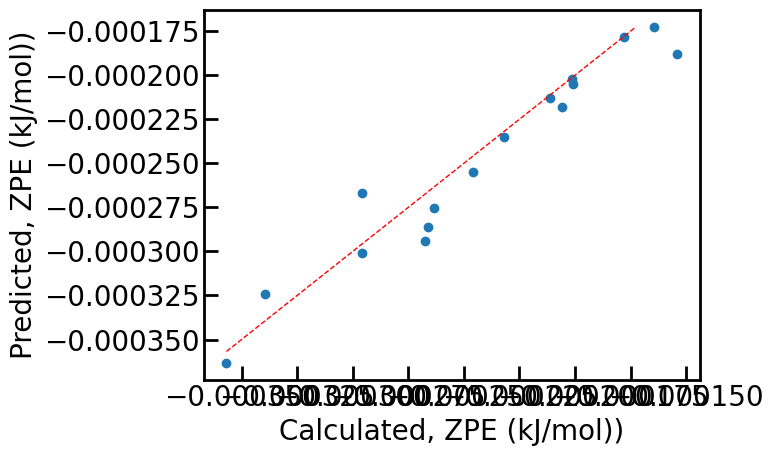

gpr4 0.9442923082602929
RMSE:  0.24098066814640143
RMSE unscaled:  1.3679005822363735e-05
----------------------------------------


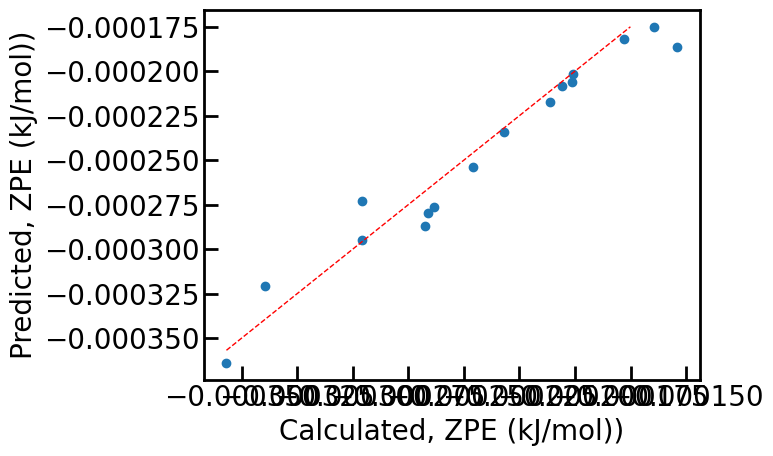

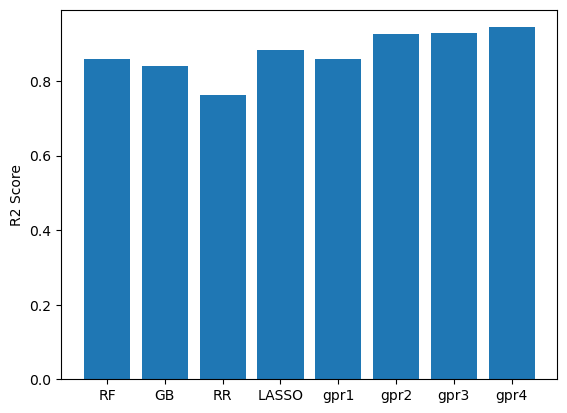

In [11]:
run_models()

In [12]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
4   mean_A2B  102.371089
28      X_EA   90.548702
2        s_X   85.083841
35      X_Ra   78.914925
17       X_Z   71.625402
7   mean_X2X   55.090616
33    A_Rvdw   45.465232
1        s_B   39.736608
5   mean_A2X   38.135020
0        s_A   37.175852
20     A_IEI   29.620602
12     E_coh   28.664366
25    X_IEII   19.175870
31    A_ChiA   15.731188
42      B_Hf   14.790160
9    std_A2X   13.719223
26      A_EA   13.666585
29    A_ChiP   13.194527
36      B_MP   12.292807
45   X_Kappa   10.015558
37      A_BP    9.616479
10   std_B2X    9.326688
43   A_Kappa    8.175236
15       A_Z    7.696321
44   B_Kappa    7.448738
16       B_Z    7.102929
14        OF    6.463180
34      B_Ra    6.019041
32    X_ChiA    5.910743
46     A_CvM    5.169814


In [13]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 's_X', 'X_Ra', 'X_Z', 'mean_X2X', 'A_Rvdw',
       's_B', 'mean_A2X', 's_A', 'A_IEI', 'E_coh', 'X_IEII', 'A_ChiA',
       'B_Hf', 'std_A2X', 'A_EA', 'A_ChiP', 'B_MP', 'X_Kappa', 'A_BP',
       'std_B2X', 'A_Kappa', 'A_Z', 'B_Kappa', 'B_Z', 'OF', 'B_Ra',
       'X_ChiA', 'A_CvM', 'A_G', 'B_Rho', 'B_EA', 'X_MV', 'A_B',
       'std_A2B', 'X_IEI', 'B_CvM', 'B_ChiP', 'std_X2X'], dtype=object)

In [14]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(40,'Score')['Feature'].values]

RF 0.8683573423259392
RMSE:  0.3704443224625683
RMSE unscaled:  2.1027869508389562e-05
----------------------------------------


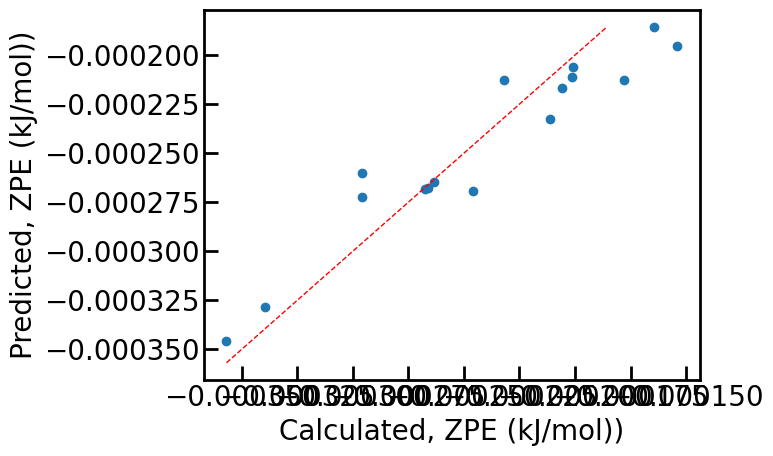

GB 0.8515030017012216
RMSE:  0.3934444829160013
RMSE unscaled:  2.2333448628813753e-05
----------------------------------------


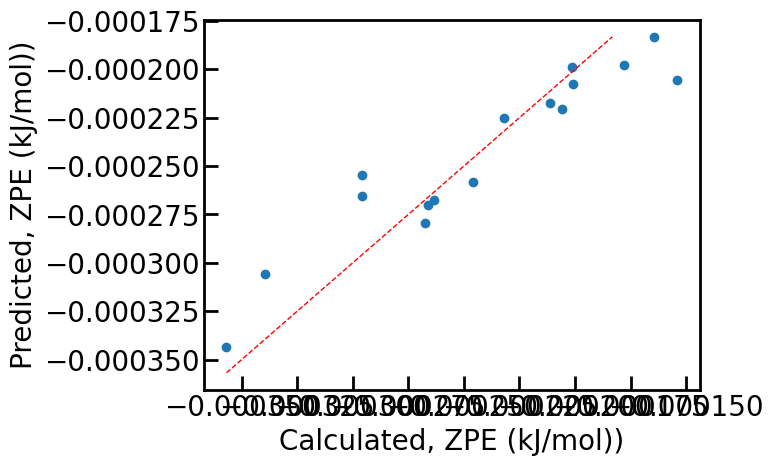

RR 0.8529507650393859
RMSE:  0.3915218525927974
RMSE unscaled:  2.222431260729114e-05
----------------------------------------


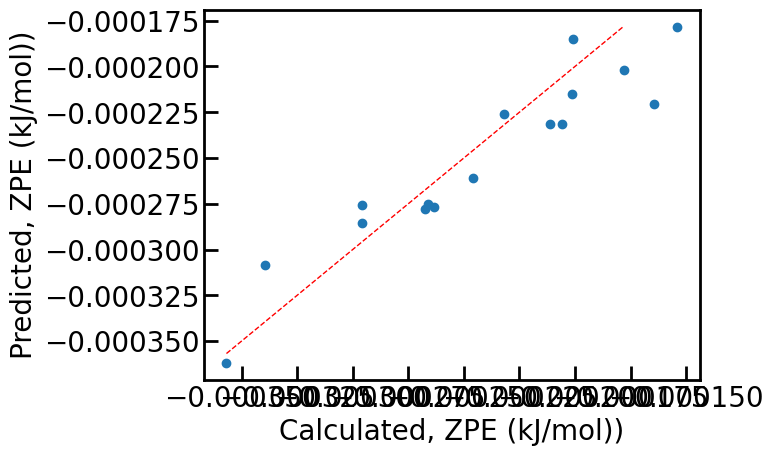

LASSO 0.8757571217582584
RMSE:  0.359882206217676
RMSE unscaled:  2.0428322454587776e-05
----------------------------------------


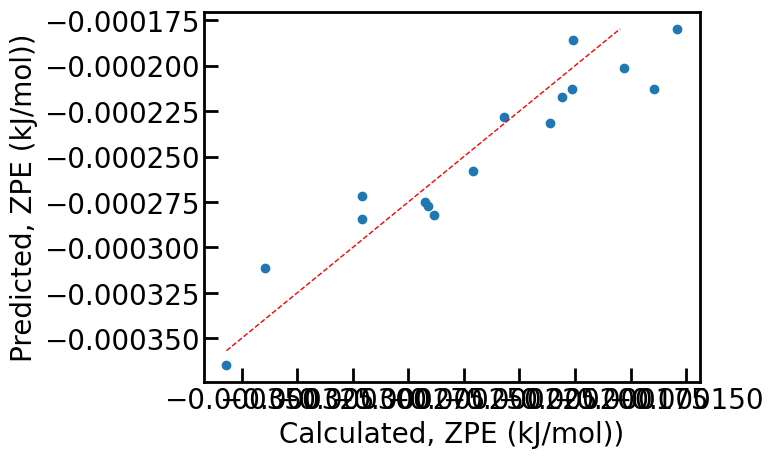

gpr1 0.8703888976835109
RMSE:  0.3675747956092214
RMSE unscaled:  2.0864983934055812e-05
----------------------------------------


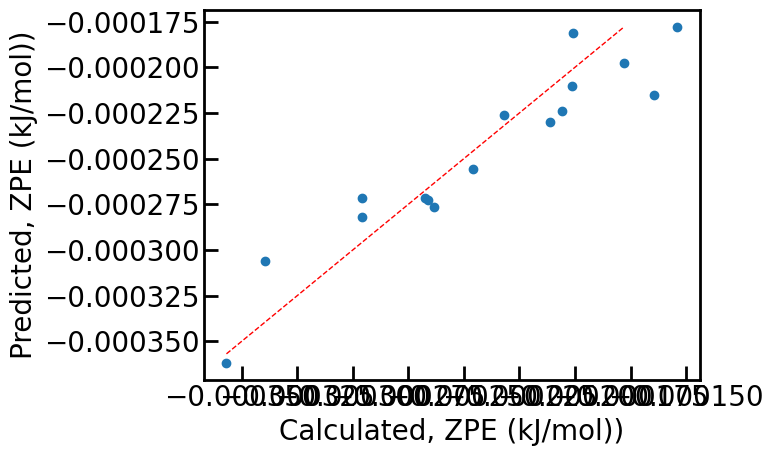

gpr2 0.8928203078671055
RMSE:  0.33425728008103317
RMSE unscaled:  1.8973751361740494e-05
----------------------------------------


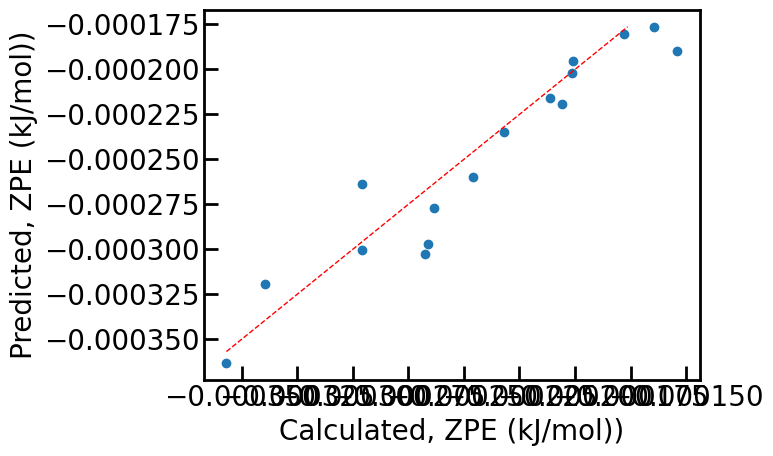

gpr3 0.8955213015951266
RMSE:  0.3300186619024909
RMSE unscaled:  1.8733150805733103e-05
----------------------------------------


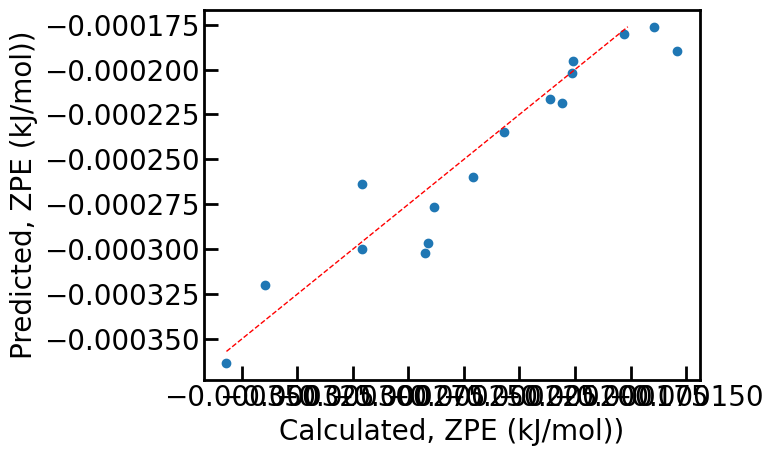

gpr4 0.9280589149313054
RMSE:  0.273850232664966
RMSE unscaled:  1.5544810942278365e-05
----------------------------------------


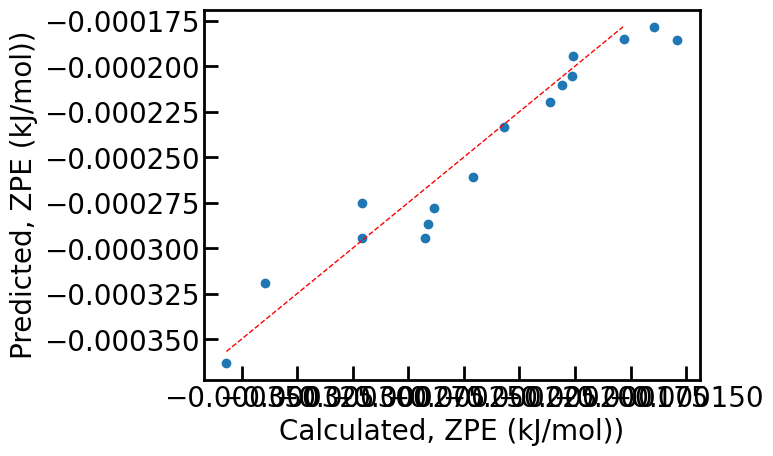

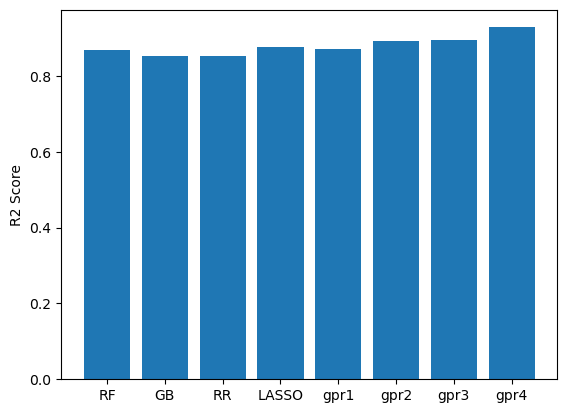

In [15]:
run_models()

In [16]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 's_X', 'X_Ra', 'X_Z', 'mean_X2X', 'A_Rvdw',
       's_B', 'mean_A2X', 's_A', 'A_IEI', 'E_coh', 'X_IEII', 'A_ChiA',
       'B_Hf', 'std_A2X', 'A_EA', 'A_ChiP', 'B_MP', 'X_Kappa', 'A_BP',
       'std_B2X', 'A_Kappa', 'A_Z', 'B_Kappa', 'B_Z', 'OF', 'B_Ra',
       'X_ChiA', 'A_CvM'], dtype=object)

In [17]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(30,'Score')['Feature'].values]

RF 0.8378635244580539
RMSE:  0.41111657484581293
RMSE unscaled:  2.3336585727987117e-05
----------------------------------------


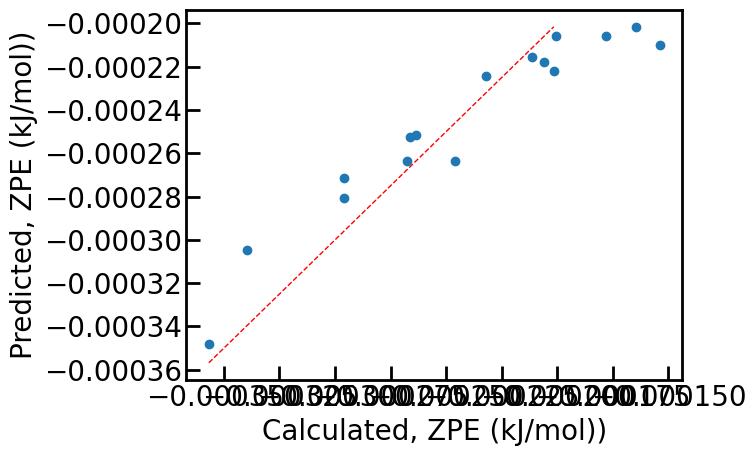

GB 0.8571594779550111
RMSE:  0.3858782823401029
RMSE unscaled:  2.1903961473155236e-05
----------------------------------------


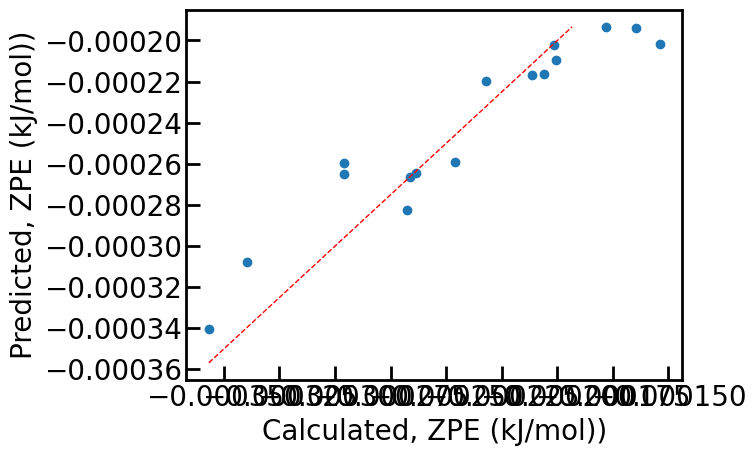

RR 0.8370068974632796
RMSE:  0.412201184628445
RMSE unscaled:  2.3398152423962095e-05
----------------------------------------


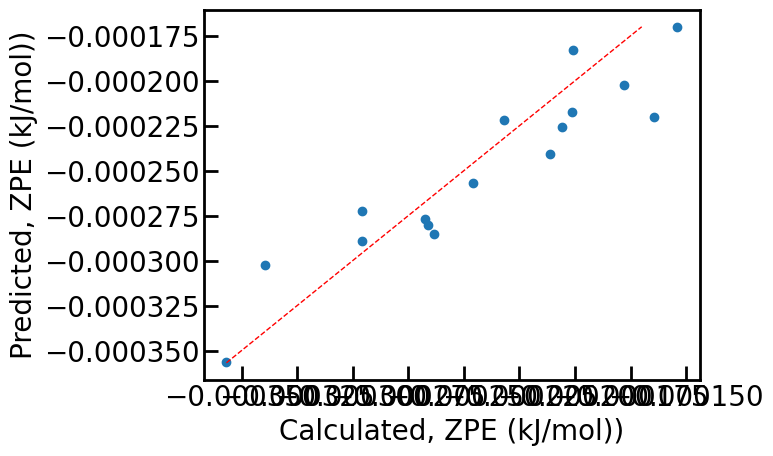

LASSO 0.8717834649746028
RMSE:  0.365591963454287
RMSE unscaled:  2.0752430620959166e-05
----------------------------------------


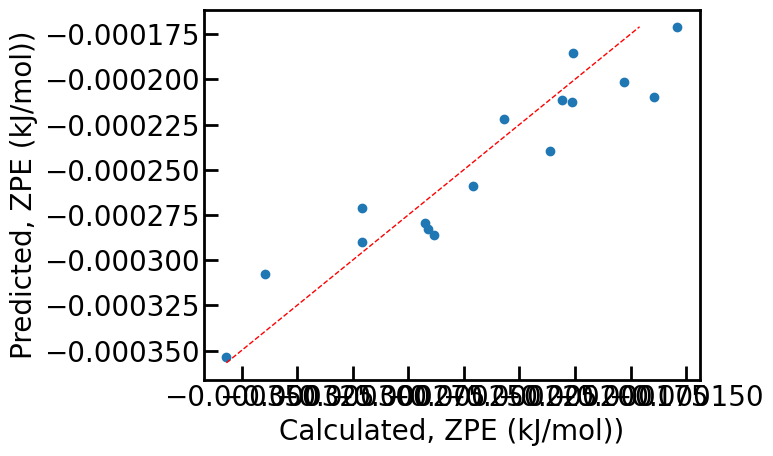

gpr1 0.8675986825798201
RMSE:  0.3715102286490549
RMSE unscaled:  2.1088374515049217e-05
----------------------------------------


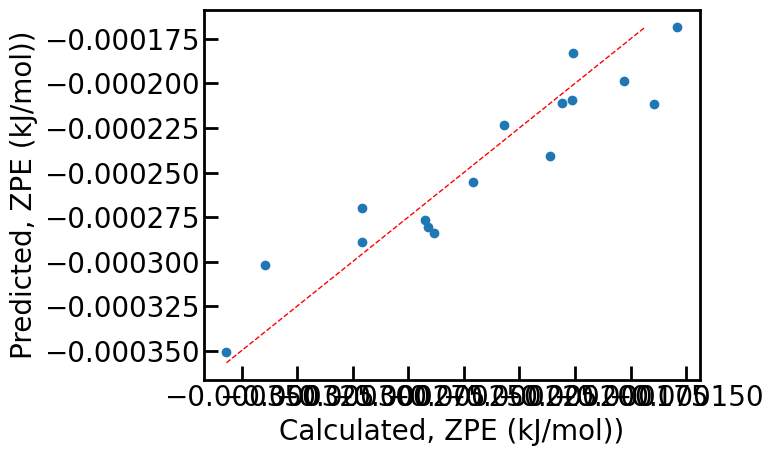

gpr2 0.8997763437887335
RMSE:  0.32322857181589576
RMSE unscaled:  1.834771871882196e-05
----------------------------------------


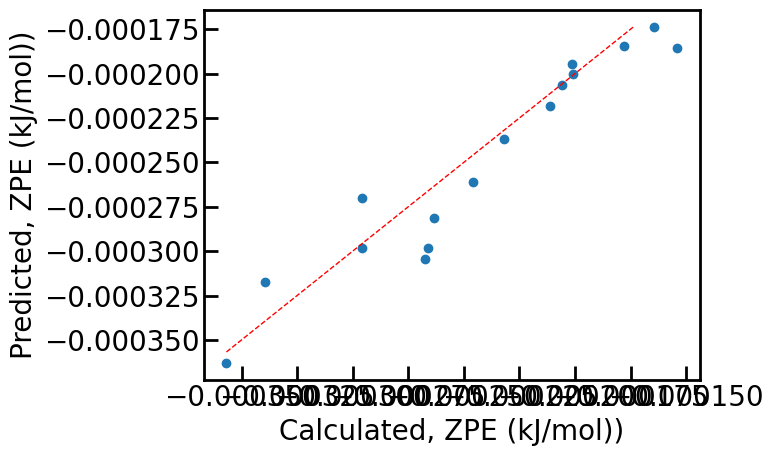

gpr3 0.8827133878590954
RMSE:  0.34966232676121667
RMSE unscaled:  1.9848202100270252e-05
----------------------------------------


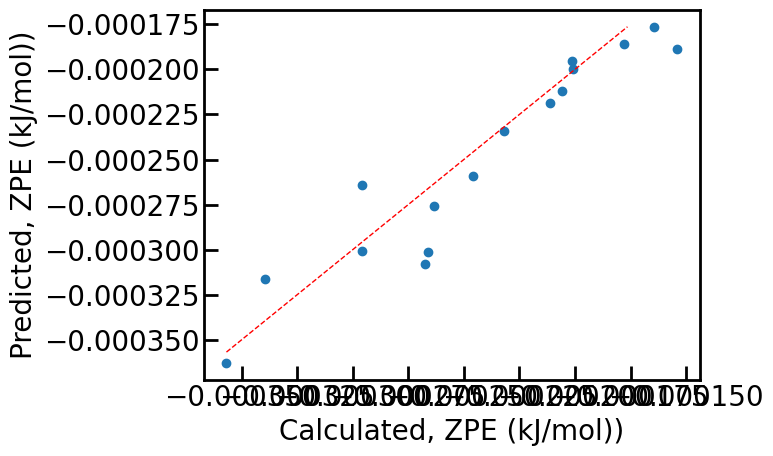

gpr4 0.9189924018562174
RMSE:  0.29059457350206197
RMSE unscaled:  1.6495285258596255e-05
----------------------------------------


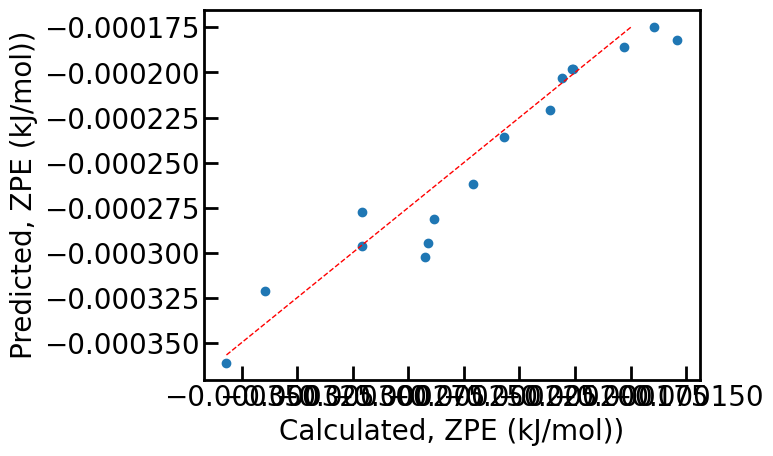

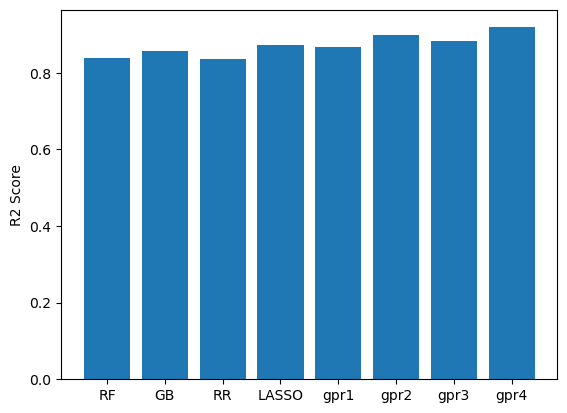

In [18]:
run_models()

In [19]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 's_X', 'X_Ra', 'X_Z', 'mean_X2X', 'A_Rvdw',
       's_B', 'mean_A2X', 's_A', 'A_IEI', 'E_coh', 'X_IEII', 'A_ChiA',
       'B_Hf', 'std_A2X', 'A_EA', 'A_ChiP', 'B_MP', 'X_Kappa'],
      dtype=object)

In [20]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(20,'Score')['Feature'].values]

RF 0.9103297877254732
RMSE:  0.30573750787041093
RMSE unscaled:  1.7354857476507422e-05
----------------------------------------


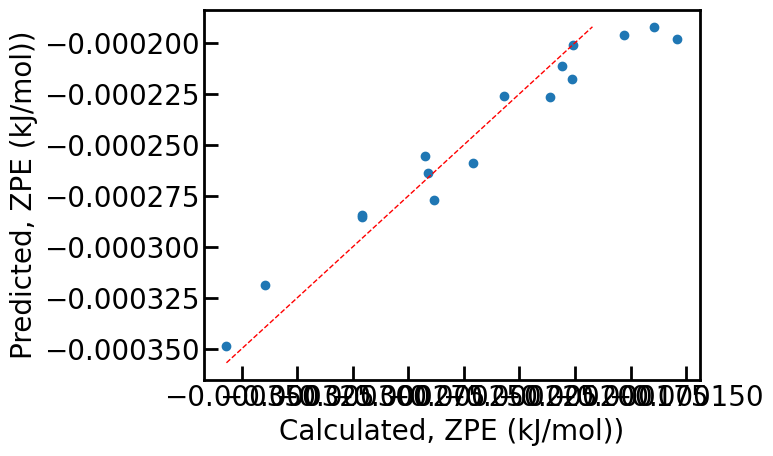

GB 0.8832355401771631
RMSE:  0.3488831216587761
RMSE unscaled:  1.980397136917018e-05
----------------------------------------


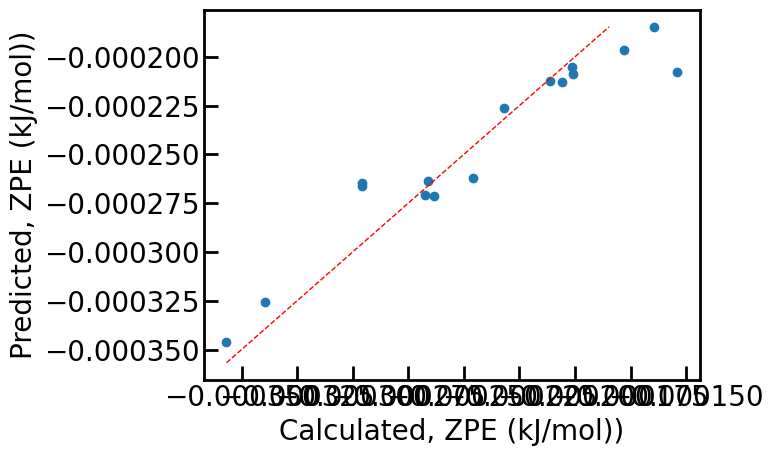

RR 0.9123346217557196
RMSE:  0.30230036934273397
RMSE unscaled:  1.715975204214204e-05
----------------------------------------


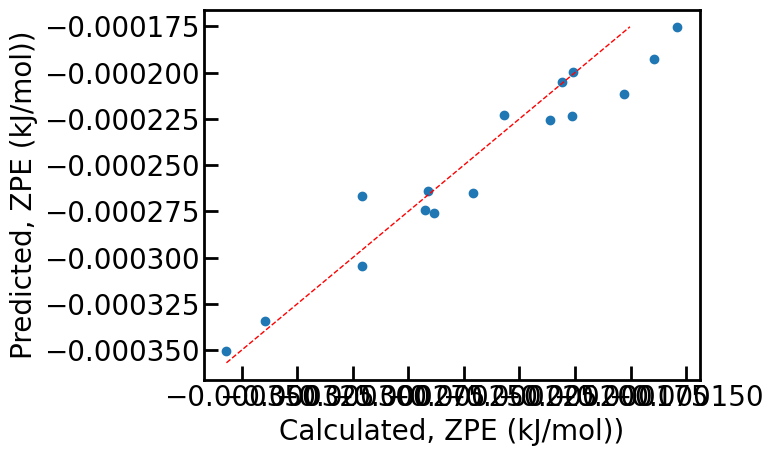

LASSO 0.9161282818639146
RMSE:  0.29568710973131856
RMSE unscaled:  1.678435754504323e-05
----------------------------------------


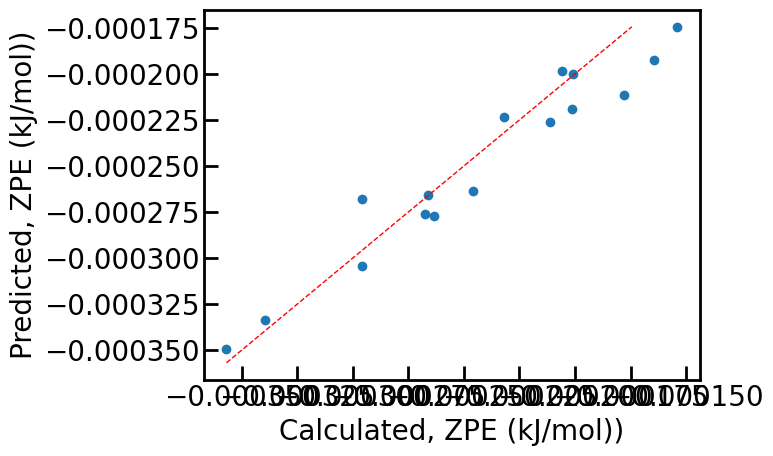

gpr1 0.9217036668305217
RMSE:  0.28569019400839335
RMSE unscaled:  1.621689348482867e-05
----------------------------------------


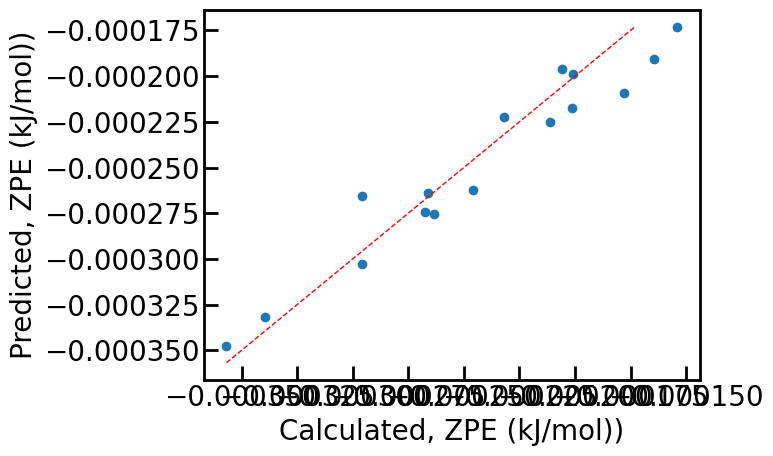

gpr2 0.9379792111871481
RMSE:  0.25426891219606323
RMSE unscaled:  1.443329855929765e-05
----------------------------------------


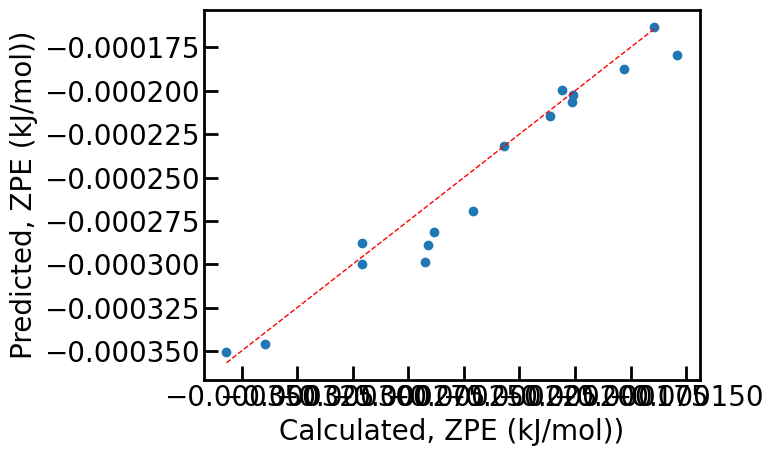

gpr3 0.9197219639014547
RMSE:  0.28928305287850803
RMSE unscaled:  1.6420838215255647e-05
----------------------------------------


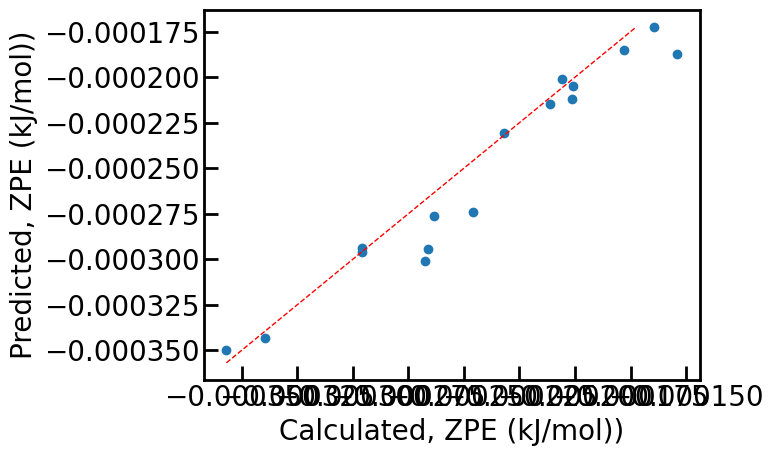

gpr4 0.9247328542939706
RMSE:  0.28010918233394705
RMSE unscaled:  1.5900093420422467e-05
----------------------------------------


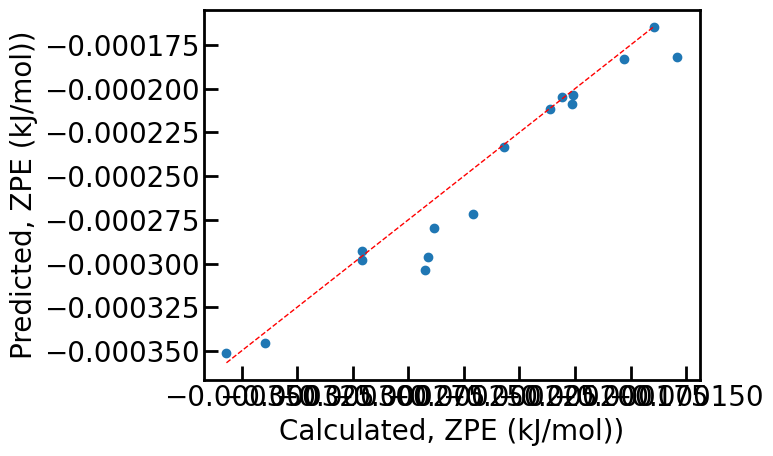

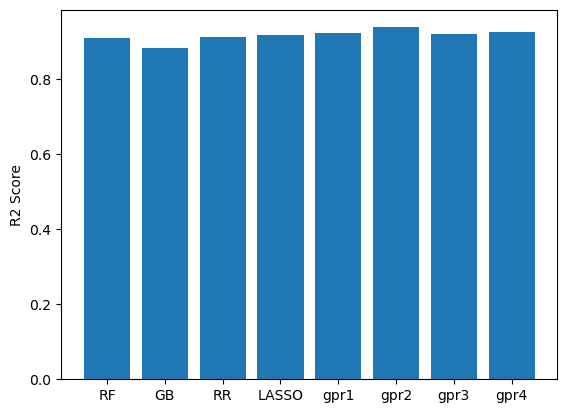

In [21]:
run_models()

In [22]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 's_X', 'X_Ra', 'X_Z', 'mean_X2X', 'A_Rvdw',
       's_B', 'mean_A2X', 's_A'], dtype=object)

In [23]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(10,'Score')['Feature'].values]

RF 0.9137561165322715
RMSE:  0.29983945122320915
RMSE unscaled:  1.7020060698665105e-05
----------------------------------------


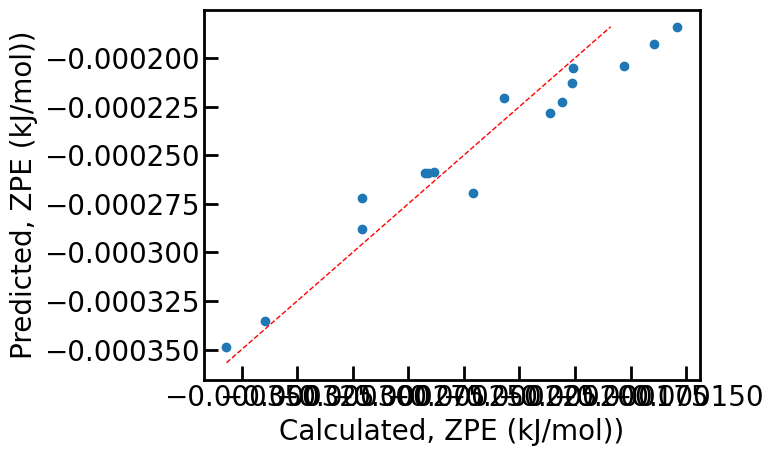

GB 0.8568006563911628
RMSE:  0.38636264980286594
RMSE unscaled:  2.193145606595499e-05
----------------------------------------


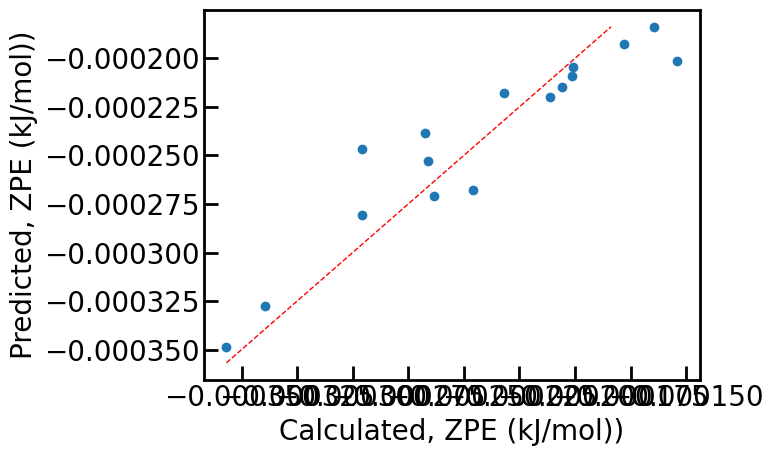

RR 0.9382208130064653
RMSE:  0.2537731770026201
RMSE unscaled:  1.4405158689615908e-05
----------------------------------------


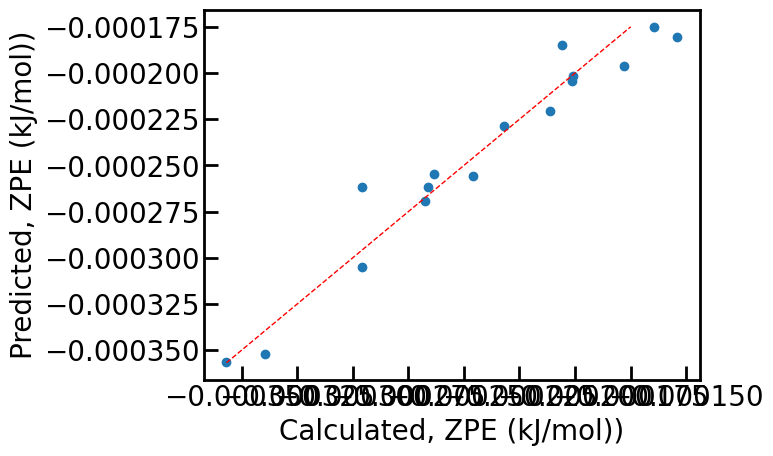

LASSO 0.9343621168041453
RMSE:  0.26157841606463006
RMSE unscaled:  1.48482146052436e-05
----------------------------------------


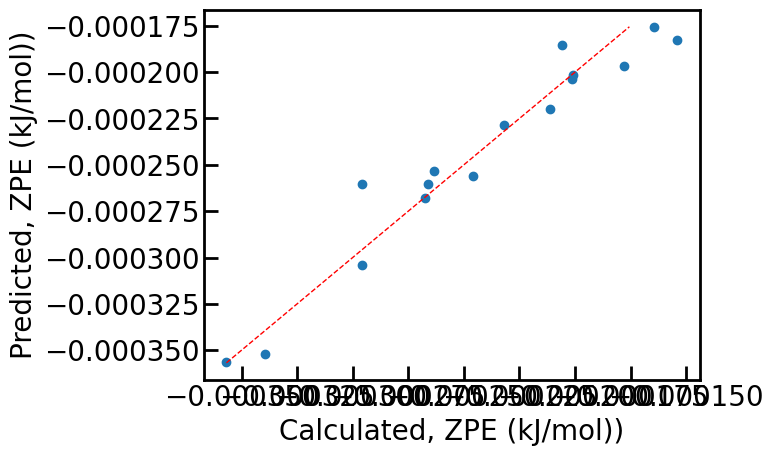

gpr1 0.9360877569914056
RMSE:  0.25811702567799516
RMSE unscaled:  1.4651732540452047e-05
----------------------------------------


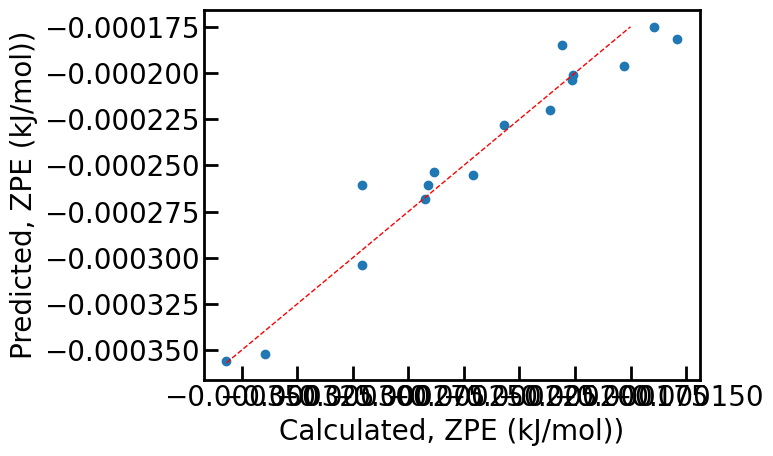

gpr2 0.950410199162258
RMSE:  0.2273635304927665
RMSE unscaled:  1.2906043797315165e-05
----------------------------------------


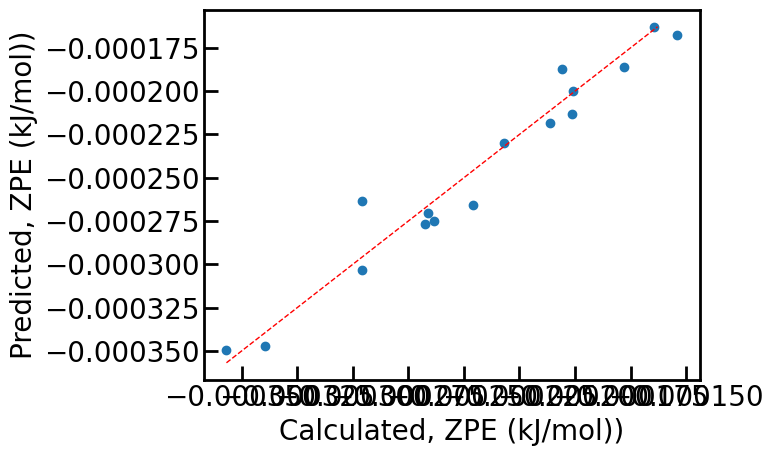

gpr3 0.9731892019071128
RMSE:  0.16717814166189535
RMSE unscaled:  9.489685586628516e-06
----------------------------------------


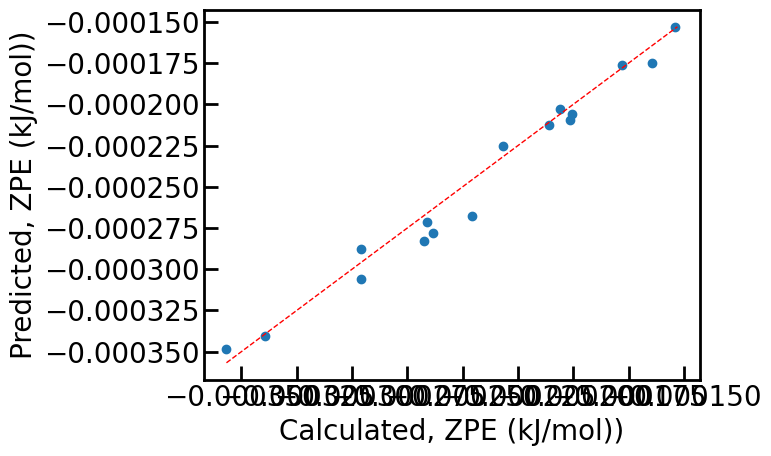

gpr4 0.9577212331351601
RMSE:  0.20993544896915883
RMSE unscaled:  1.1916757683753438e-05
----------------------------------------


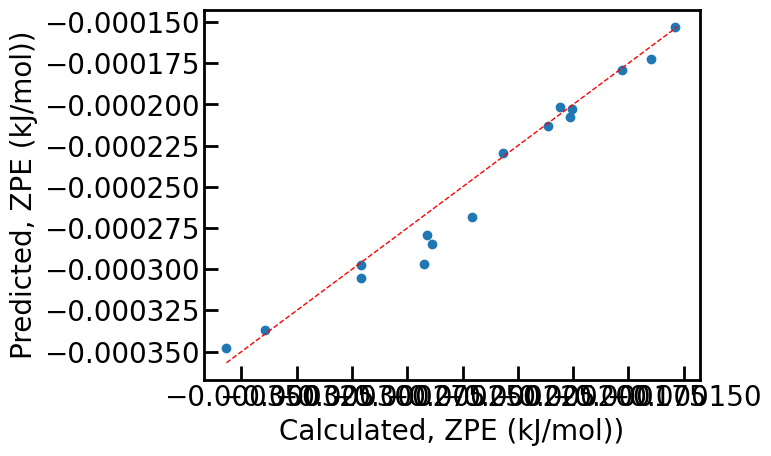

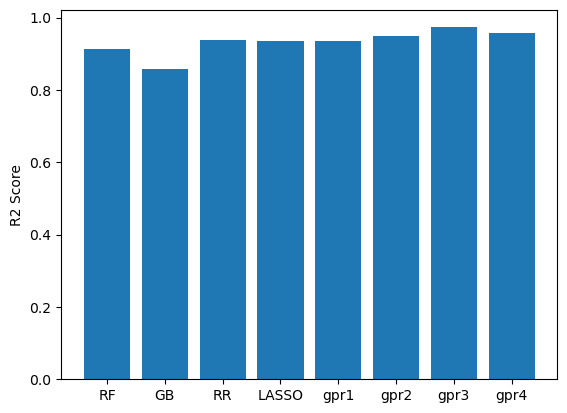

In [24]:
run_models()

# Min-Max scaling

In [25]:
data_std=d.copy()
scaler=MinMaxScaler()
scaler.fit(np.array(data[target]).reshape(-1, 1))
data_zpe_mm= scaler.transform(np.array(data[target]).reshape(-1, 1))
data_std[columns]= MinMaxScaler().fit_transform(d[columns])
Y = data_std[target] 
X = data_std.drop([target], axis=1)

In [26]:
correlated_features = ["A_Rc","A_Ra","A_M","A_MP","A_MV","A_MendeleevNo","A_Hf","A_Hv","B_Rc",
                       "B_Rvdw","B_M","B_BP","B_MendeleevNo","B_Hv","X_Rc","X_Rvdw","X_M","X_BP","X_MP",
                       "X_MendeleevNo","X_Hf","X_Hv","X_G","X_B","X_CvM","X_ChiP"]
data_std.drop(labels=correlated_features, axis=1, inplace=True)
print(data_std.shape)
Y = data_std[target] 
X = data_std.drop([target], axis=1)

(80, 51)


### Test-train splitting 

In [27]:
# split into train and test
df_train, df_test = train_test_split(data_std, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state = 50)
df_train.reset_index(inplace = True)
df_test.reset_index(inplace = True)
df_train=df_train.drop('index',axis=1)
df_test=df_test.drop('index',axis=1)
# divide into X_train, y_train, X_test, y_test
Y = df_train.pop(target)
X = df_train

Y_test = df_test.pop(target)
X_test = df_test

RF 0.9097635067101083
RMSE:  0.08190902987241903
RMSE unscaled:  1.7409570513135105e-05
----------------------------------------


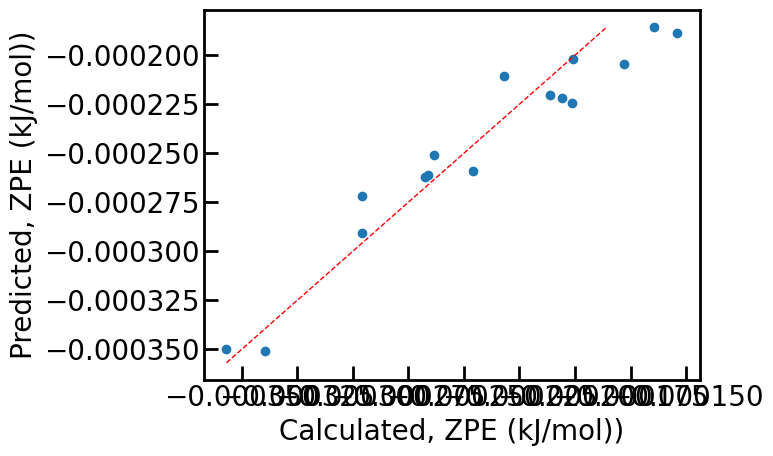

GB 0.8967112204776746
RMSE:  0.08763291338999343
RMSE unscaled:  1.8626168412822104e-05
----------------------------------------


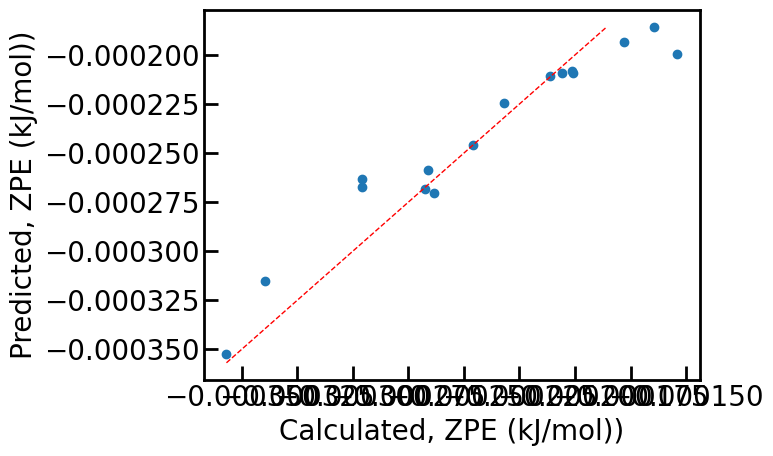

RR 0.8624679541686815
RMSE:  0.101121296459696
RMSE unscaled:  2.1493092322504936e-05
----------------------------------------


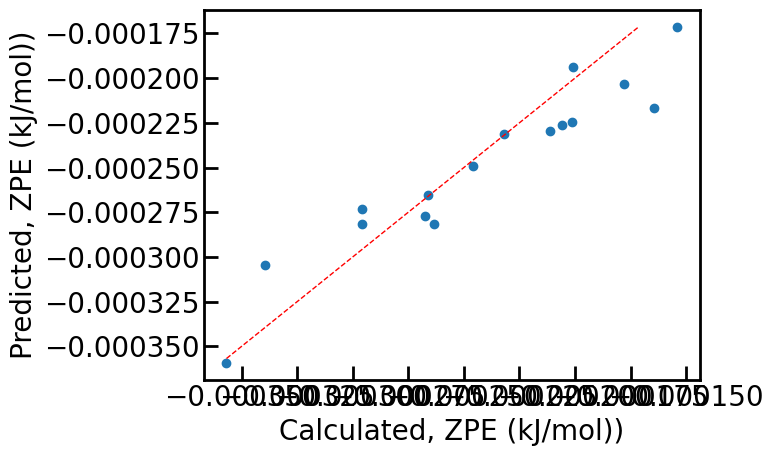

LASSO 0.8944039791774383
RMSE:  0.08860626981602002
RMSE unscaled:  1.883305301833772e-05
----------------------------------------


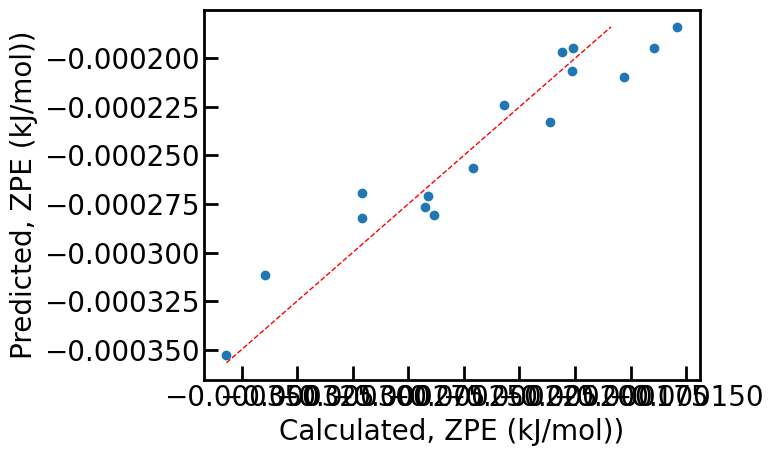

gpr1 0.8554950572219832
RMSE:  0.10365303633506283
RMSE unscaled:  2.2031207643242688e-05
----------------------------------------


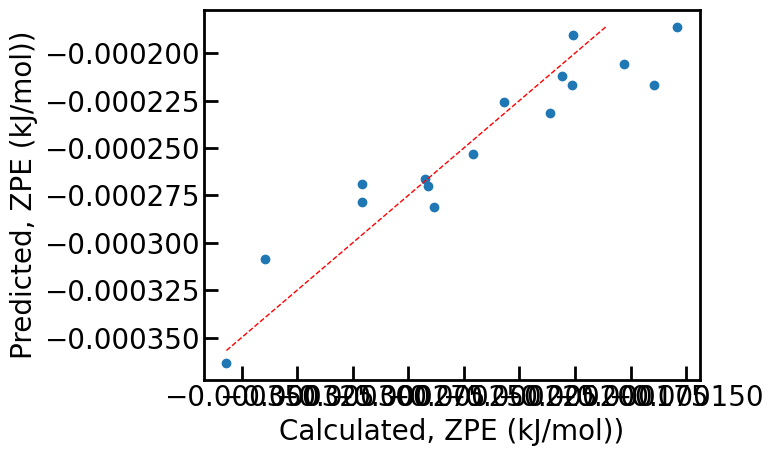

gpr2 0.9440886673810076
RMSE:  0.06447488840632634
RMSE unscaled:  1.3703984991457273e-05
----------------------------------------


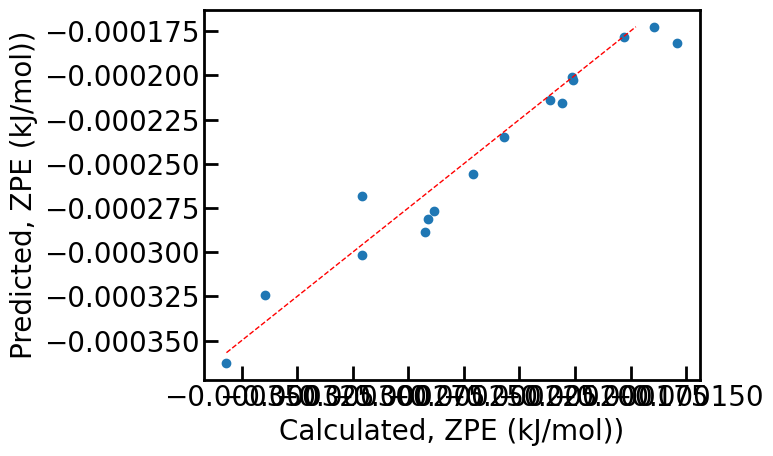

gpr3 0.9563613076855467
RMSE:  0.0569608604757115
RMSE unscaled:  1.210689613203037e-05
----------------------------------------


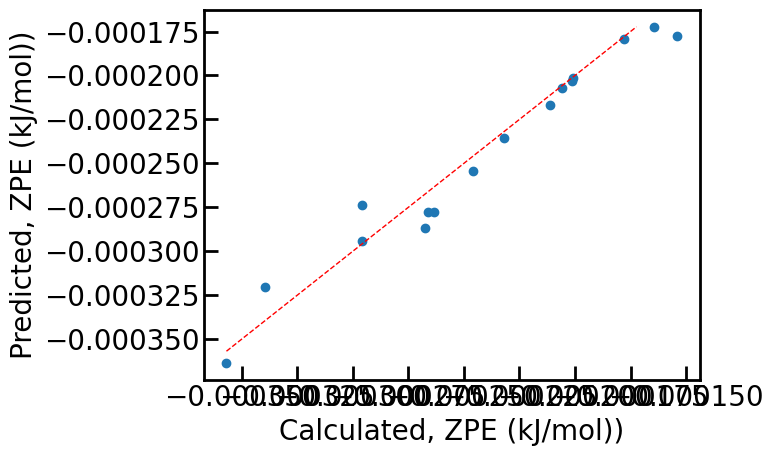

gpr4 0.9171157159194221
RMSE:  0.07850128622724943
RMSE unscaled:  1.6685262663638216e-05
----------------------------------------


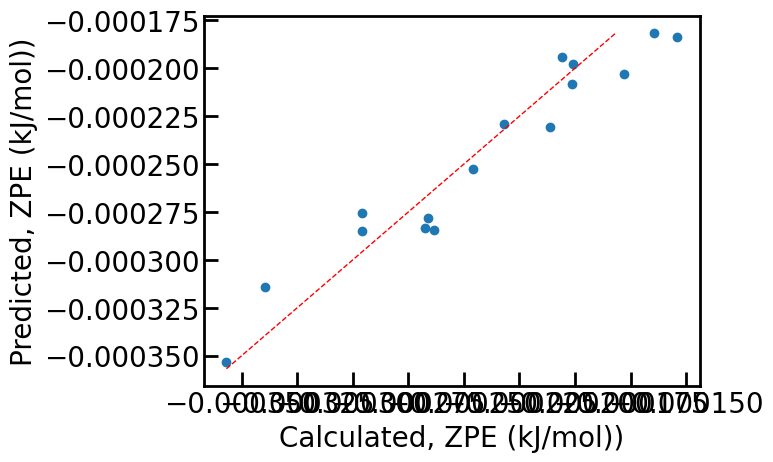

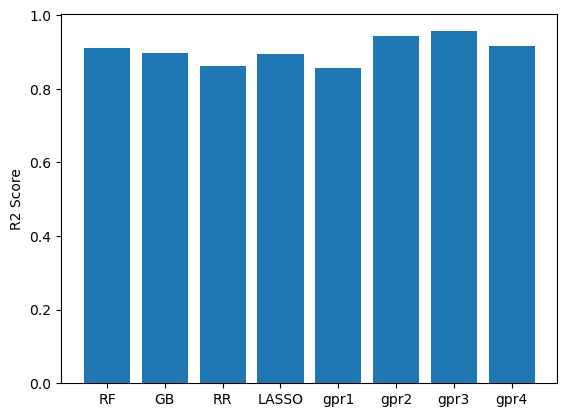

In [28]:
run_models()

## Feature selection


In [29]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
4   mean_A2B  102.371089
28      X_EA   90.548702
2        s_X   85.083841
35      X_Ra   78.914925
17       X_Z   71.625402
7   mean_X2X   55.090616
33    A_Rvdw   45.465232
1        s_B   39.736608
5   mean_A2X   38.135020
0        s_A   37.175852
20     A_IEI   29.620602
12     E_coh   28.664366
25    X_IEII   19.175870
31    A_ChiA   15.731188
42      B_Hf   14.790160
9    std_A2X   13.719223
26      A_EA   13.666585
29    A_ChiP   13.194527
36      B_MP   12.292807
45   X_Kappa   10.015558
37      A_BP    9.616479
10   std_B2X    9.326688
43   A_Kappa    8.175236
15       A_Z    7.696321
44   B_Kappa    7.448738
16       B_Z    7.102929
14        OF    6.463180
34      B_Ra    6.019041
32    X_ChiA    5.910743
46     A_CvM    5.169814


In [30]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 's_X', 'X_Ra', 'X_Z', 'mean_X2X', 'A_Rvdw',
       's_B', 'mean_A2X', 's_A', 'A_IEI', 'E_coh', 'X_IEII', 'A_ChiA',
       'B_Hf', 'std_A2X', 'A_EA', 'A_ChiP', 'B_MP', 'X_Kappa', 'A_BP',
       'std_B2X', 'A_Kappa', 'A_Z', 'B_Kappa', 'B_Z', 'OF', 'B_Ra',
       'X_ChiA', 'A_CvM', 'A_G', 'B_Rho', 'B_EA', 'X_MV', 'A_B',
       'std_A2B', 'X_IEI', 'B_CvM', 'B_ChiP', 'std_X2X'], dtype=object)

In [31]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(40,'Score')['Feature'].values]

RF 0.8803750404232888
RMSE:  0.09430866112991712
RMSE unscaled:  2.004508280098089e-05
----------------------------------------


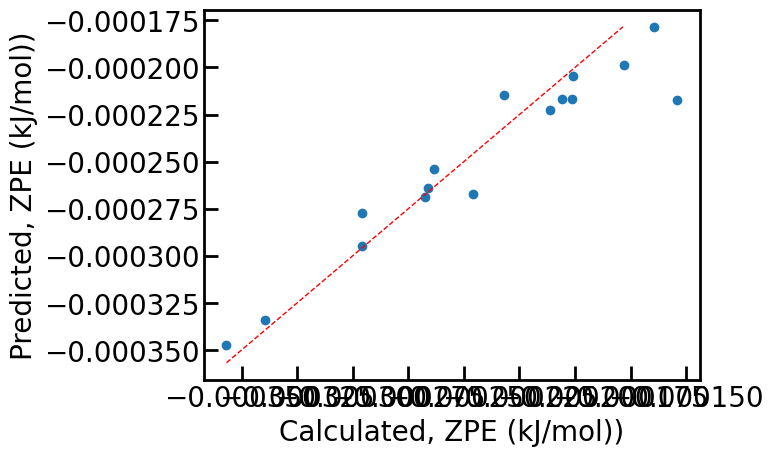

GB 0.8076304815474469
RMSE:  0.11959383876968363
RMSE unscaled:  2.5419387486829588e-05
----------------------------------------


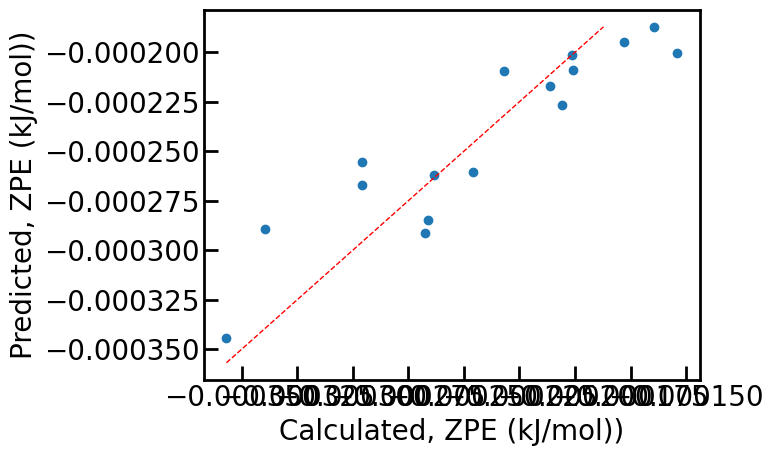

RR 0.868654923767784
RMSE:  0.09882062033588684
RMSE unscaled:  2.10040890554936e-05
----------------------------------------


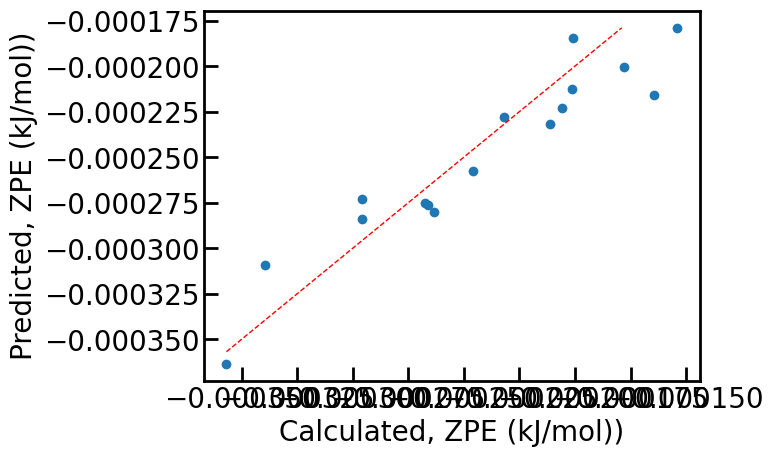

LASSO 0.8932943080147333
RMSE:  0.08907061902890832
RMSE unscaled:  1.8931749344946508e-05
----------------------------------------


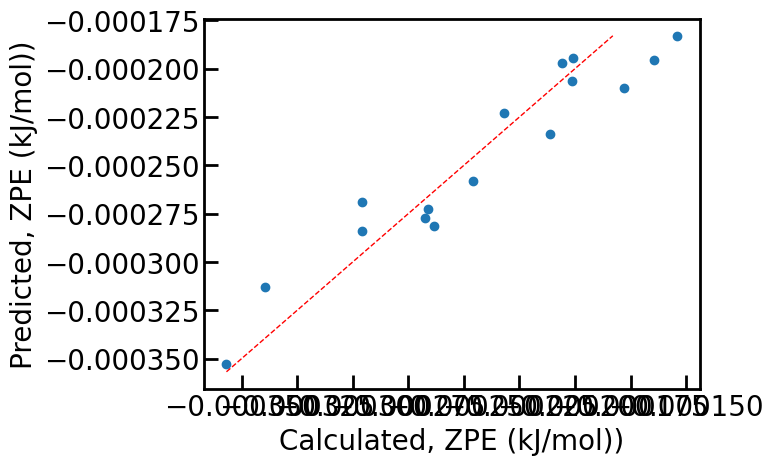

gpr1 0.8597869791240321
RMSE:  0.10210214134634076
RMSE unscaled:  2.1701568582608216e-05
----------------------------------------


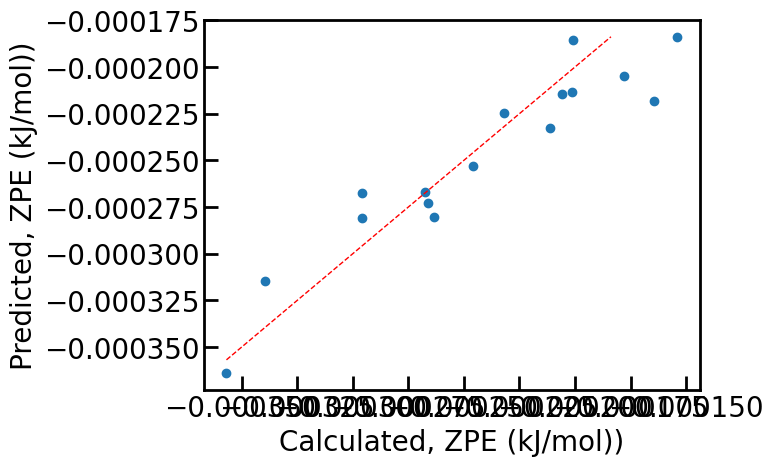

gpr2 0.9125749309426057
RMSE:  0.08062294710055425
RMSE unscaled:  1.713621666268195e-05
----------------------------------------


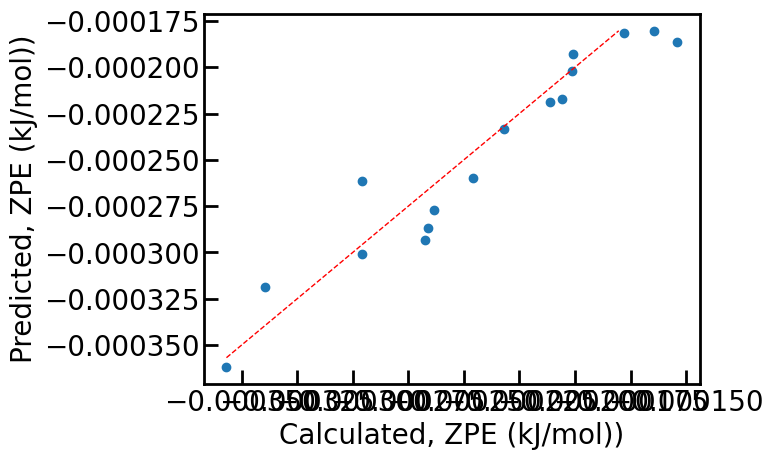

gpr3 0.9345186992848253
RMSE:  0.06977491661424351
RMSE unscaled:  1.4830493447863852e-05
----------------------------------------


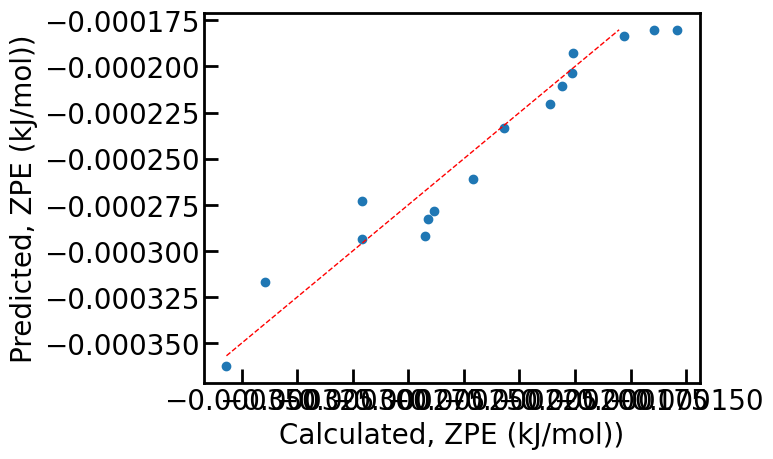

gpr4 0.9177746123396212
RMSE:  0.07818863694566043
RMSE unscaled:  1.6618809798524528e-05
----------------------------------------


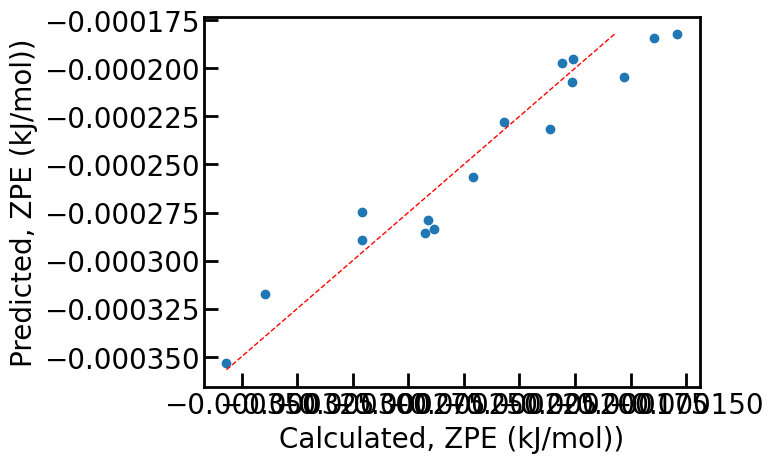

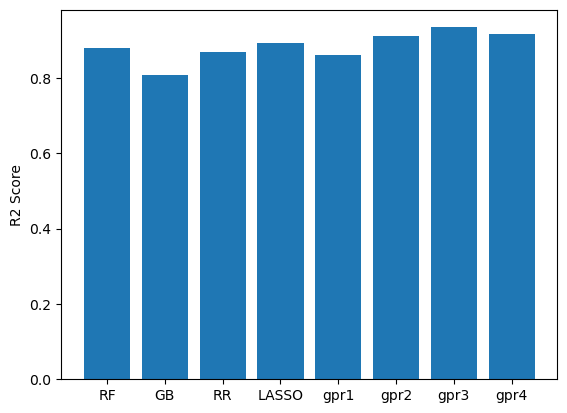

In [32]:
run_models()

In [33]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 's_X', 'X_Ra', 'X_Z', 'mean_X2X', 'A_Rvdw',
       's_B', 'mean_A2X', 's_A', 'A_IEI', 'E_coh', 'X_IEII', 'A_ChiA',
       'B_Hf', 'std_A2X', 'A_EA', 'A_ChiP', 'B_MP', 'X_Kappa', 'A_BP',
       'std_B2X', 'A_Kappa', 'A_Z', 'B_Kappa', 'B_Z', 'OF', 'B_Ra',
       'X_ChiA', 'A_CvM'], dtype=object)

In [34]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(30,'Score')['Feature'].values]

RF 0.9512135639582171
RMSE:  0.06022686035944226
RMSE unscaled:  1.2801076680380976e-05
----------------------------------------


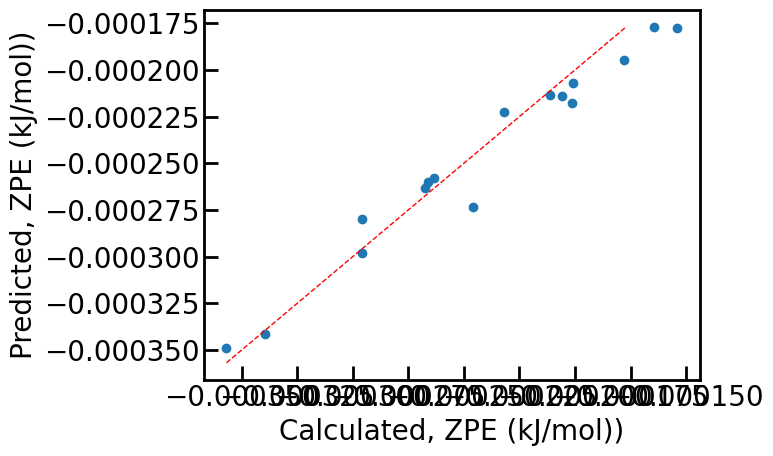

GB 0.8378610715541306
RMSE:  0.10979544584623227
RMSE unscaled:  2.333676225268953e-05
----------------------------------------


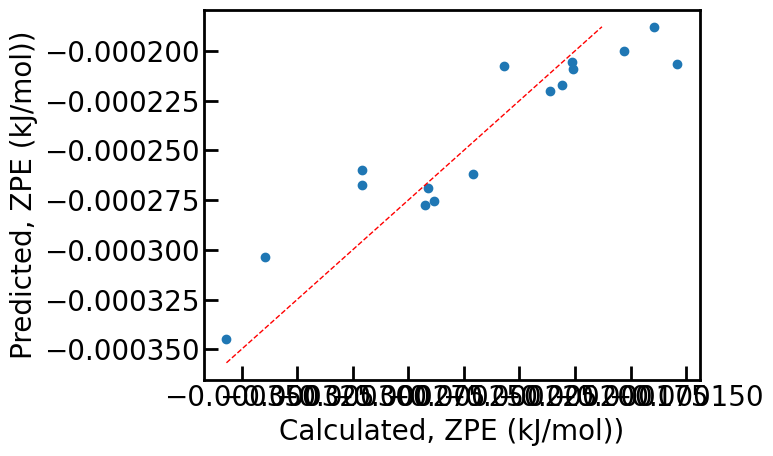

RR 0.870594825444963
RMSE:  0.09808813988992061
RMSE unscaled:  2.084840206965817e-05
----------------------------------------


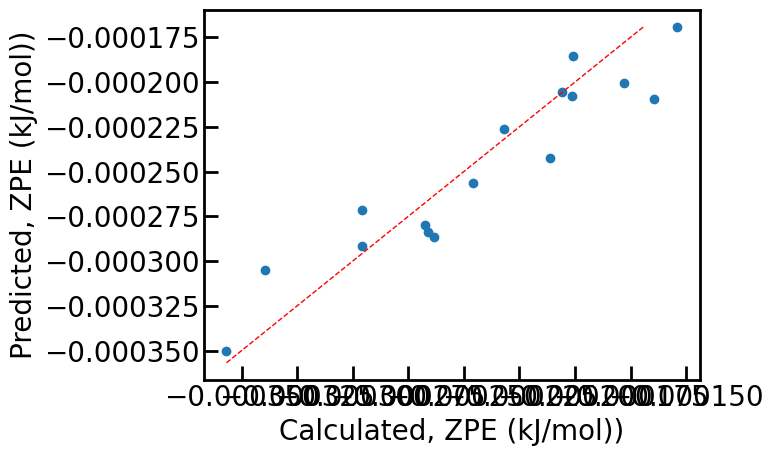

LASSO 0.9058971181538384
RMSE:  0.08364541479684225
RMSE unscaled:  1.7778635020757486e-05
----------------------------------------


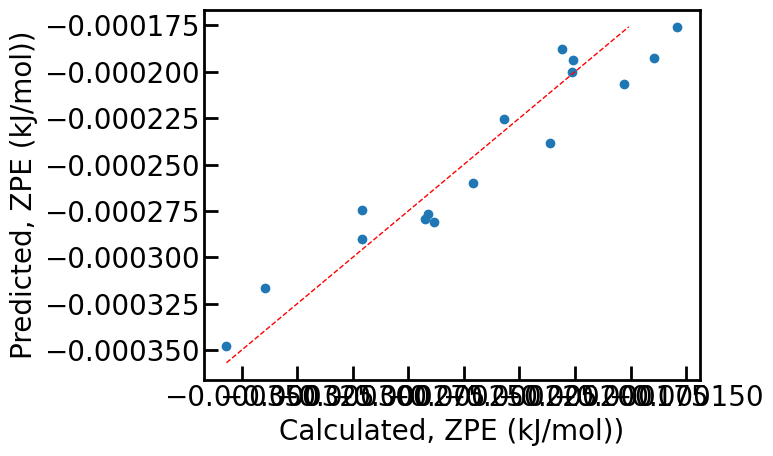

gpr1 0.8652427577974995
RMSE:  0.10009600274988523
RMSE unscaled:  2.1275168570197926e-05
----------------------------------------


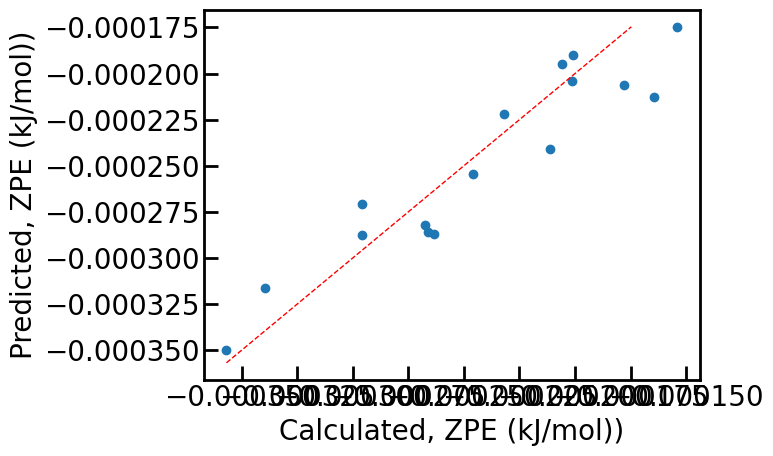

gpr2 0.9174046612640713
RMSE:  0.07836433394134237
RMSE unscaled:  1.6656153779280198e-05
----------------------------------------


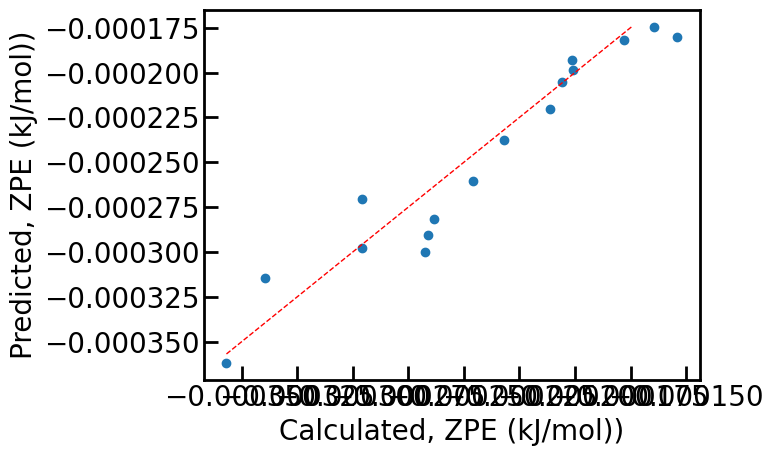

gpr3 0.9244816380248152
RMSE:  0.07493193677801452
RMSE unscaled:  1.5926605882825833e-05
----------------------------------------


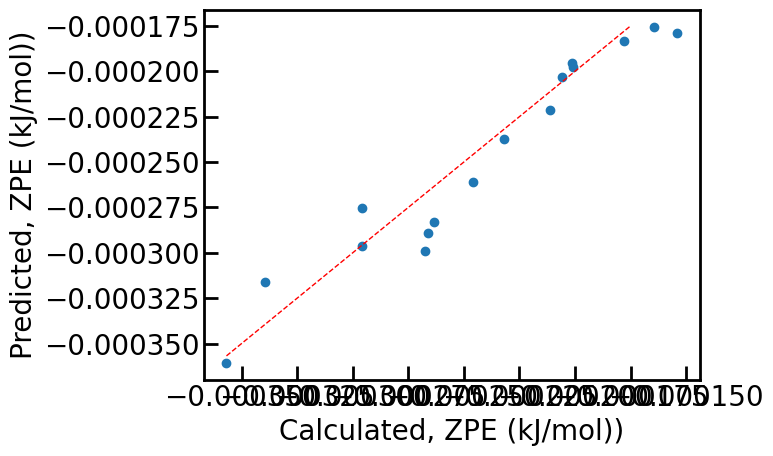

gpr4 0.9241749737874272
RMSE:  0.07508392408099121
RMSE unscaled:  1.595891042449108e-05
----------------------------------------


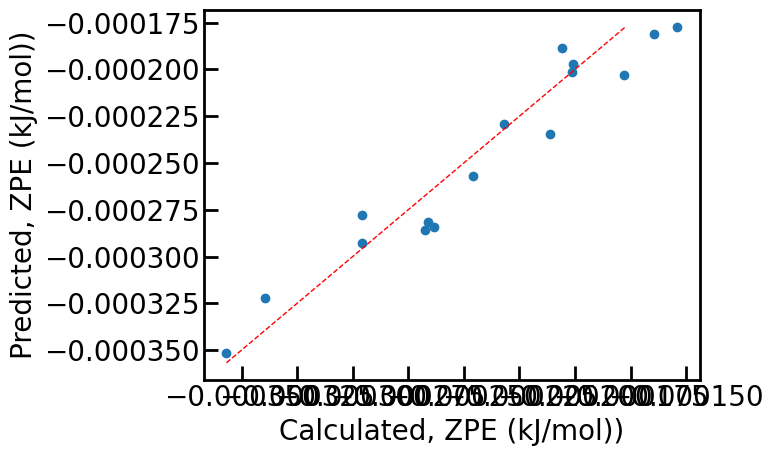

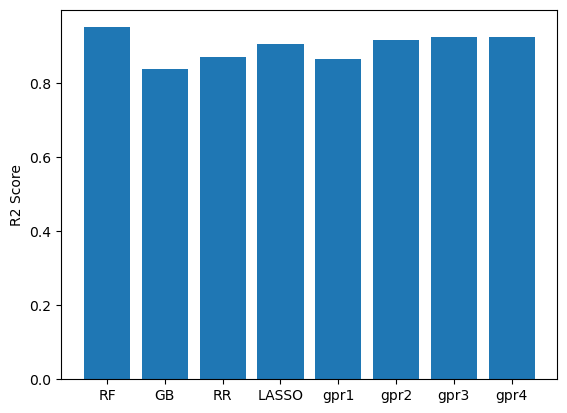

In [35]:
run_models()

In [36]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 's_X', 'X_Ra', 'X_Z', 'mean_X2X', 'A_Rvdw',
       's_B', 'mean_A2X', 's_A', 'A_IEI', 'E_coh', 'X_IEII', 'A_ChiA',
       'B_Hf', 'std_A2X', 'A_EA', 'A_ChiP', 'B_MP', 'X_Kappa'],
      dtype=object)

In [37]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(20,'Score')['Feature'].values]

RF 0.882088533596657
RMSE:  0.09363079212882262
RMSE unscaled:  1.9901003348549267e-05
----------------------------------------


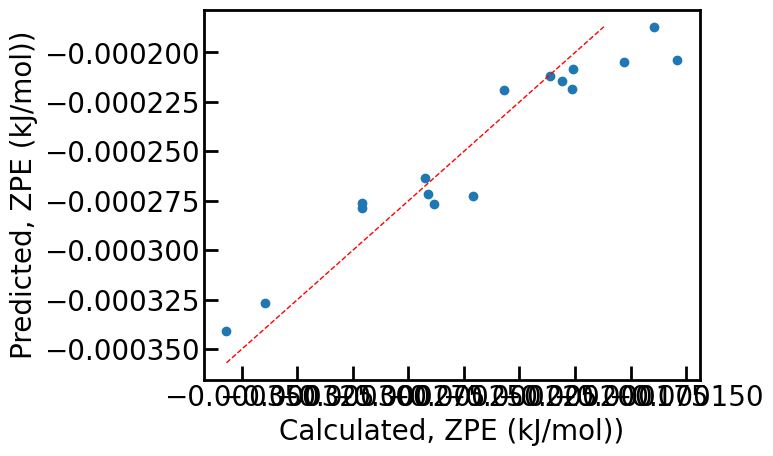

GB 0.8708833086260941
RMSE:  0.09797874485667853
RMSE unscaled:  2.0825150414157168e-05
----------------------------------------


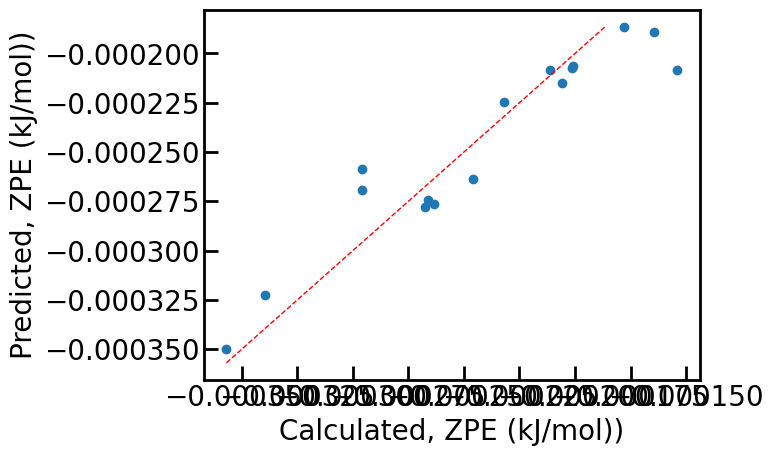

RR 0.9177082514981655
RMSE:  0.0782201820524625
RMSE unscaled:  1.6625514636343643e-05
----------------------------------------


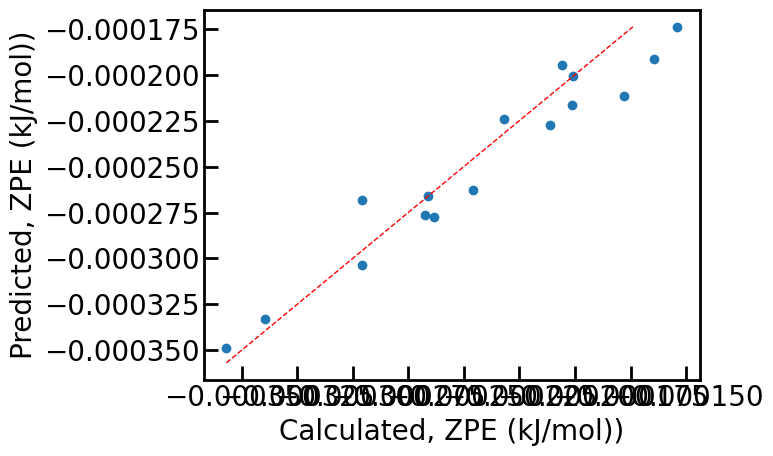

LASSO 0.915150587105114
RMSE:  0.07942644015145067
RMSE unscaled:  1.6881901941431796e-05
----------------------------------------


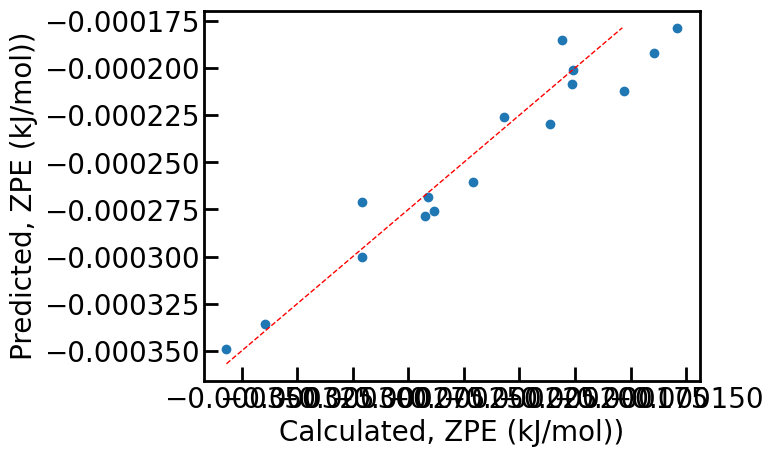

gpr1 0.876516520078211
RMSE:  0.0958175599981342
RMSE unscaled:  2.036579568555944e-05
----------------------------------------


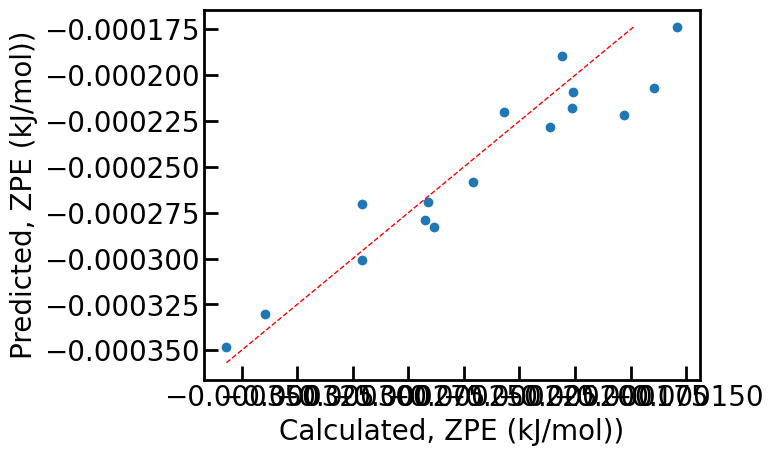

gpr2 0.9402424898556995
RMSE:  0.06665564331270116
RMSE unscaled:  1.4167499287421132e-05
----------------------------------------


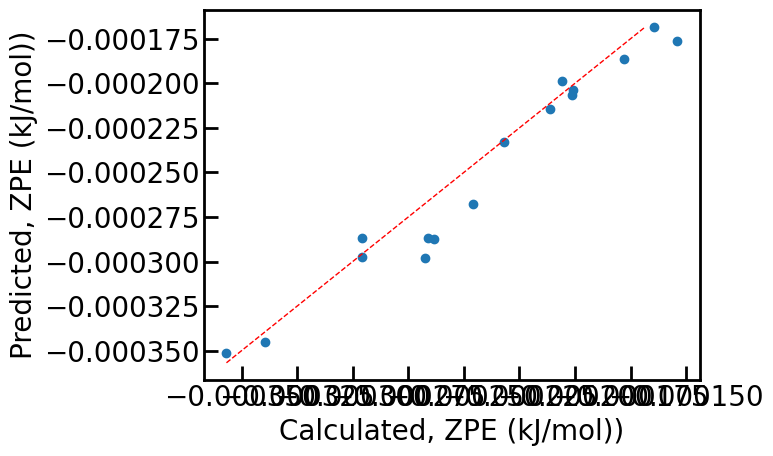

gpr3 0.9252865893455761
RMSE:  0.07453151659525059
RMSE unscaled:  1.5841497520322093e-05
----------------------------------------


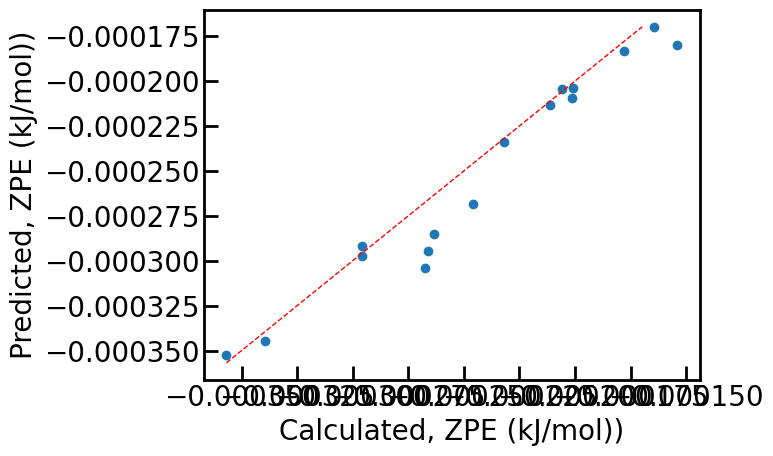

gpr4 0.9204430333462987
RMSE:  0.07690946411948085
RMSE unscaled:  1.6346924640678723e-05
----------------------------------------


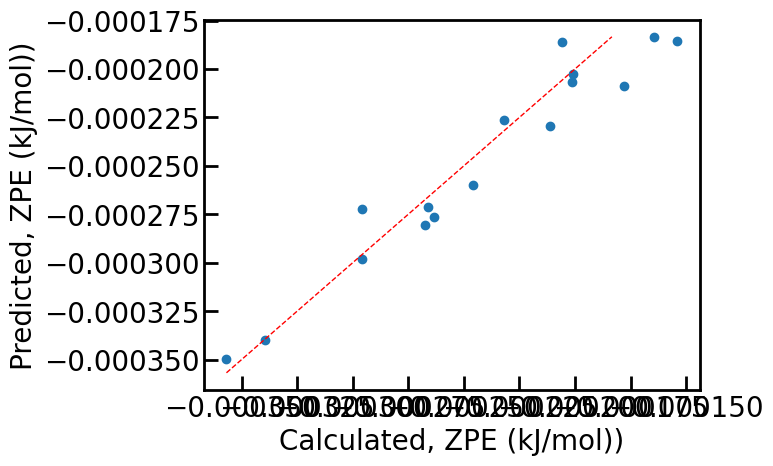

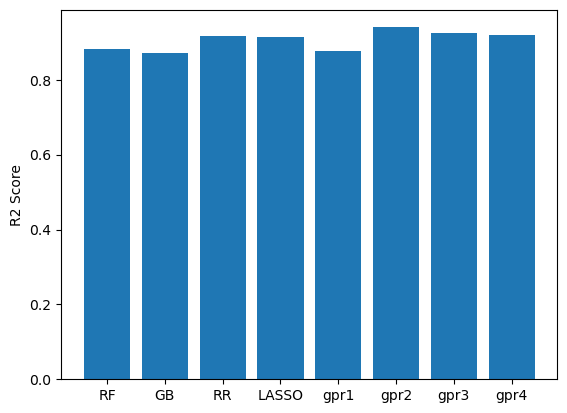

In [38]:
run_models()

In [39]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 's_X', 'X_Ra', 'X_Z', 'mean_X2X', 'A_Rvdw',
       's_B', 'mean_A2X', 's_A'], dtype=object)

In [40]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(10,'Score')['Feature'].values]

RF 0.8491934123194568
RMSE:  0.1058889968405769
RMSE unscaled:  2.250645575869425e-05
----------------------------------------


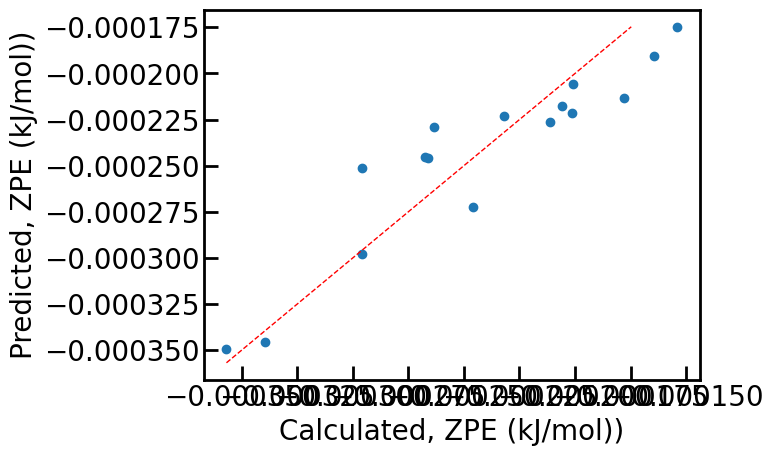

GB 0.820227410039938
RMSE:  0.11561186710205042
RMSE unscaled:  2.4573028829707817e-05
----------------------------------------


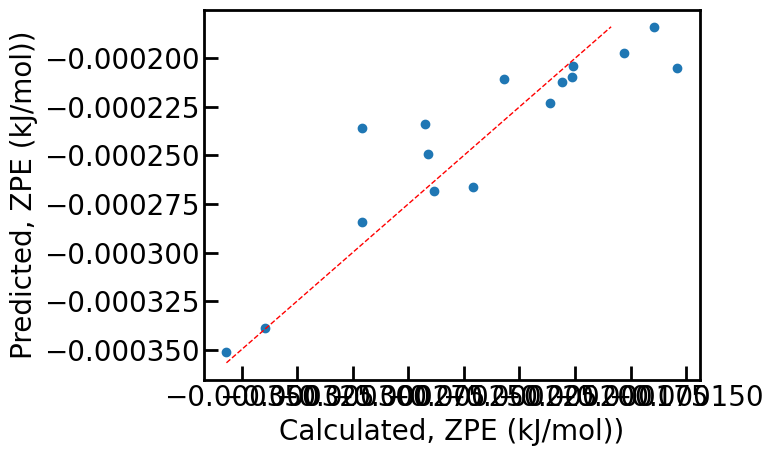

RR 0.9345267440756061
RMSE:  0.06977063033830362
RMSE unscaled:  1.4829582410053607e-05
----------------------------------------


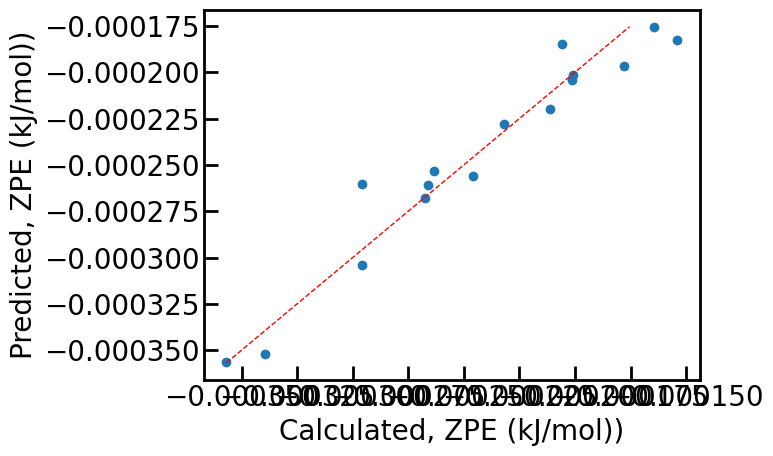

LASSO 0.9020484134175886
RMSE:  0.08533877703164212
RMSE unscaled:  1.8138555157486586e-05
----------------------------------------


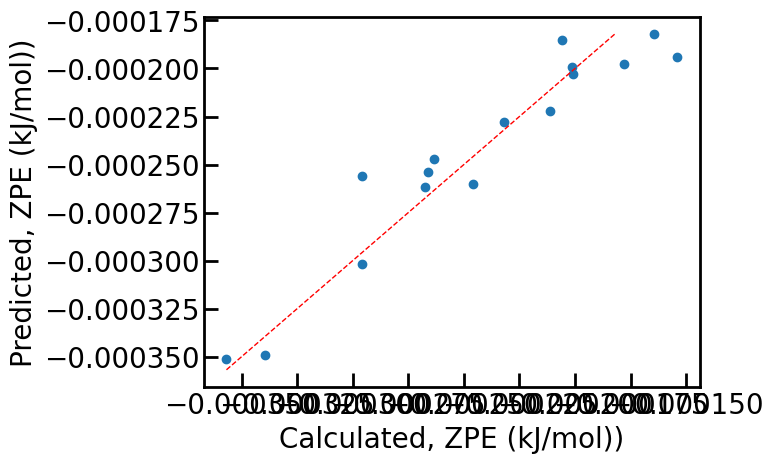

gpr1 0.9030306157940198
RMSE:  0.08490983485064914
RMSE unscaled:  1.8047384511738644e-05
----------------------------------------


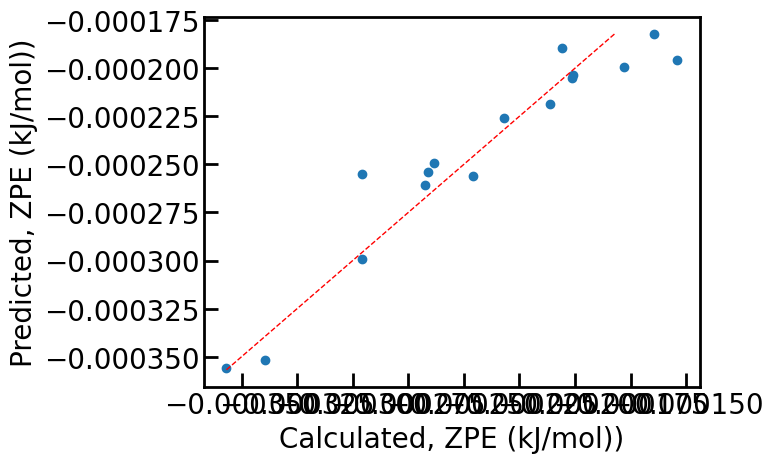

gpr2 0.942114366344092
RMSE:  0.06560335849755032
RMSE unscaled:  1.3943838639531587e-05
----------------------------------------


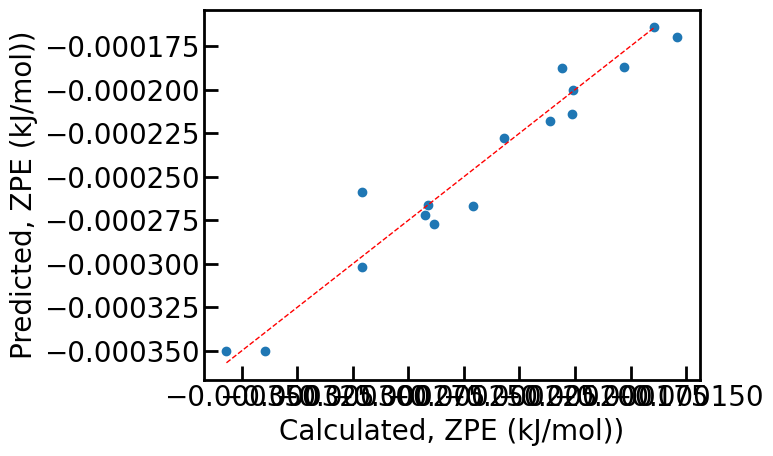

gpr3 0.9630107297172638
RMSE:  0.052441917045613025
RMSE unscaled:  1.1146405397202864e-05
----------------------------------------


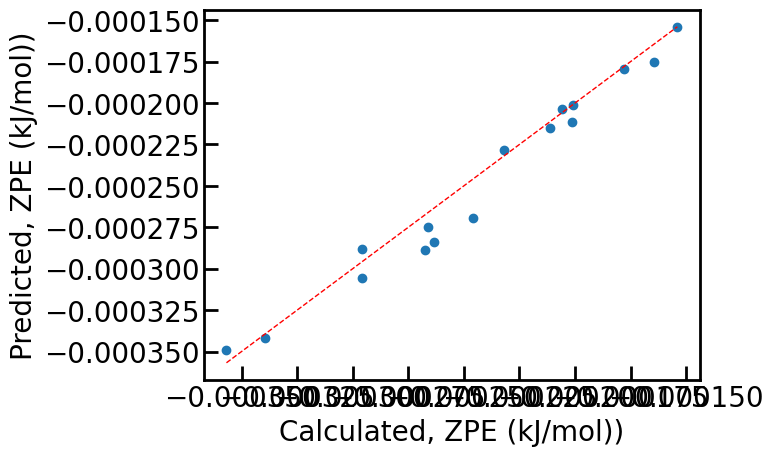

gpr4 0.9348157891573927
RMSE:  0.06961645162660345
RMSE unscaled:  1.479681208964877e-05
----------------------------------------


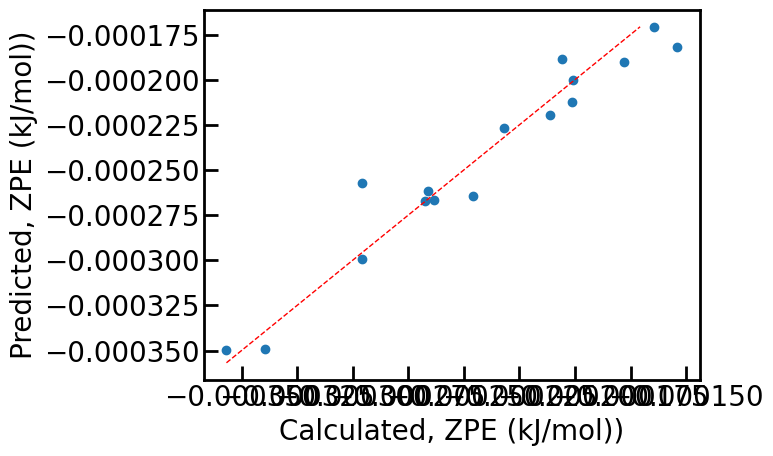

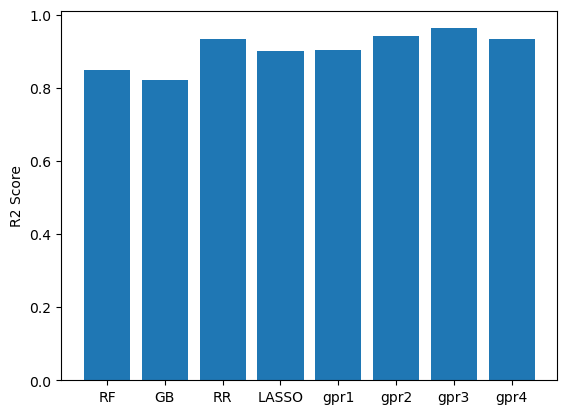

In [41]:
run_models()